# Infidelity Risk Early Warning System
###### *Anti-Jule

---

**Project Overview:**
- AI untuk deteksi risiko selengki sebelum kejadian, bukan nuduh tapi early warning.
- Dataset: 8 CSV files dengan 3000 responden (Dummy generated by ChatGPT).
- Model yang digunakan adalah XGBoost.
- Evaluasi menggunakan SHAP untuk mengetahui faktor-faktor yang mempengaruhi prediksi.

**Dataset:**
1. 📁 **kepuasan_hubungan.csv**:
   - Columns: Kepuasan hubungan, kualitas komunikasi, merasa diperhatikan, keintiman emosional, konflik berulang.
   - 📌 Ini penyebab nomor 1 perselengkian terjadi.

2. 📁 **profil_psikologis.csv**:
   - Columns: Gaya kelekatan, kebutuhan validasi, kontrol diri, impulsif, empati pasangan.
   - 📌 Sebenernya hubungan baik-baik aja, tp emang internal orang nya ga danta.

3. 📁 **akses_dan_kesempatan.csv**:
   - Columns: Intensitas DM lawan jenis, komunikasi rahasia, lingkungan kerja intens, masih kontak mantan, hubungan jarak jauh.
   - 📌 Ga ada niat selengki, cuma mau curhat aja, eh bablas.

4. 📁 **kedekatan_emosional_lain.csv**:
   - Columns: Curhat ke orang lain, merasa lebih dimengerti orang lain, menyembunyikan interaksi, berbagi masalah pribadi ke luar.
   - 📌 Ini fase paling krusial buat early warning.

5. 📁 **nilai_dan_sikap.csv**:
   - Columns: Pandangan tentang selingkuh, religiusitas pribadi, toleransi selingkuh, nilai kesetiaan.
   - 📌 Cara orang mikir.

6. 📁 **komitmen_hubungan.csv**:
   - Columns: Status hubungan, lama hubungan tahun, punya anak, rencana masa depan bersama, ketergantungan emosional.
   - 📌 Semakin besar investasi → risiko turun.

7. 📁 **pemicu_stres.csv**:
   - Columns: Stres pekerjaan, masalah ekonomi, konflik besar terakhir, konsumsi alkohol.
   - 📌 Walau bukan penyebab utama, tapi bisa mempercepat.

8. 📁 **demografi.csv**:
   - Columns: Usia, jenis kelamin, pendidikan terakhir, status pekerjaan, domisili.
   - 📌 Dipakai buat fairness & analisis bias.

---

# Step 1: EDA

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Settings
sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
# Load semua 8 CSV files
df_kepuasan = pd.read_csv('../dataset/kepuasan_hubungan.csv')
df_psikologis = pd.read_csv('../dataset/profil_psikologis.csv')
df_akses = pd.read_csv('../dataset/akses_dan_kesempatan.csv')
df_emosional = pd.read_csv('../dataset/kedekatan_emosional_lain.csv')
df_nilai = pd.read_csv('../dataset/nilai_dan_sikap.csv')
df_komitmen = pd.read_csv('../dataset/komitmen_hubungan.csv')
df_stres = pd.read_csv('../dataset/pemicu_stres.csv')
df_demografi = pd.read_csv('../dataset/demografi.csv')

print("✅ All datasets loaded successfully!")

✅ All datasets loaded successfully!


In [3]:
# Dictionary untuk menyimpan semua dataset
datasets = {
    'kepuasan_hubungan': df_kepuasan,
    'profil_psikologis': df_psikologis,
    'akses_dan_kesempatan': df_akses,
    'kedekatan_emosional_lain': df_emosional,
    'nilai_dan_sikap': df_nilai,
    'komitmen_hubungan': df_komitmen,
    'pemicu_stres': df_stres,
    'demografi': df_demografi
}

# Inspect shape dan columns setiap dataset
for name, df in datasets.items():
    print(f"\n📁 {name.upper()}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"First 3 rows:")
    display(df.head(3))


📁 KEPUASAN_HUBUNGAN
Shape: (3000, 6)
Columns: ['responden_id', 'kepuasan_hubungan', 'kualitas_komunikasi', 'merasa_diperhatikan', 'keintiman_emosional', 'konflik_berulang']
First 3 rows:


,responden_id,kepuasan_hubungan,kualitas_komunikasi,merasa_diperhatikan,keintiman_emosional,konflik_berulang
0,1,sedang,tinggi,iya,tinggi,sering
1,2,tinggi,tinggi,tidak,sedang,jarang
2,3,tinggi,sedang,iya,tinggi,jarang



📁 PROFIL_PSIKOLOGIS
Shape: (3000, 6)
Columns: ['responden_id', 'gaya_kelekatan', 'kebutuhan_validasi', 'kontrol_diri', 'impulsif', 'empati_pasangan']
First 3 rows:


,responden_id,gaya_kelekatan,kebutuhan_validasi,kontrol_diri,impulsif,empati_pasangan
0,1,aman,sedang,tinggi,iya,tinggi
1,2,cemas,sedang,tinggi,tidak,rendah
2,3,cemas,sedang,tinggi,tidak,tinggi



📁 AKSES_DAN_KESEMPATAN
Shape: (3000, 6)
Columns: ['responden_id', 'intensitas_dm_lawan_jenis', 'komunikasi_rahasia', 'lingkungan_kerja_intens', 'masih_kontak_mantan', 'hubungan_jarak_jauh']
First 3 rows:


,responden_id,intensitas_dm_lawan_jenis,komunikasi_rahasia,lingkungan_kerja_intens,masih_kontak_mantan,hubungan_jarak_jauh
0,1,sedang,tidak,iya,tidak,iya
1,2,sedang,tidak,iya,tidak,iya
2,3,tinggi,iya,tidak,iya,tidak



📁 KEDEKATAN_EMOSIONAL_LAIN
Shape: (3000, 5)
Columns: ['responden_id', 'curhat_ke_orang_lain', 'merasa_lebih_dimengerti_orang_lain', 'menyembunyikan_interaksi', 'berbagi_masalah_pribadi_ke_luar']
First 3 rows:


,responden_id,curhat_ke_orang_lain,merasa_lebih_dimengerti_orang_lain,menyembunyikan_interaksi,berbagi_masalah_pribadi_ke_luar
0,1,tidak,iya,tidak,tidak
1,2,iya,tidak,tidak,iya
2,3,iya,tidak,tidak,iya



📁 NILAI_DAN_SIKAP
Shape: (3000, 5)
Columns: ['responden_id', 'pandangan_tentang_selingkuh', 'religiusitas_pribadi', 'toleransi_selingkuh', 'nilai_kesetiaan']
First 3 rows:


,responden_id,pandangan_tentang_selingkuh,religiusitas_pribadi,toleransi_selingkuh,nilai_kesetiaan
0,1,salah_total,tinggi,nol,kuat
1,2,salah_total,tinggi,nol,kuat
2,3,salah_total,tinggi,rendah,kuat



📁 KOMITMEN_HUBUNGAN
Shape: (3000, 6)
Columns: ['responden_id', 'status_hubungan', 'lama_hubungan_tahun', 'punya_anak', 'rencana_masa_depan_bersama', 'ketergantungan_emosional']
First 3 rows:


,responden_id,status_hubungan,lama_hubungan_tahun,punya_anak,rencana_masa_depan_bersama,ketergantungan_emosional
0,1,pacaran,4.8,tidak,jelas,tinggi
1,2,pacaran,4.0,iya,tidak_jelas,rendah
2,3,pacaran,5.0,tidak,jelas,tinggi



📁 PEMICU_STRES
Shape: (3000, 5)
Columns: ['responden_id', 'stres_pekerjaan', 'masalah_ekonomi', 'konflik_besar_terakhir', 'konsumsi_alkohol']
First 3 rows:


,responden_id,stres_pekerjaan,masalah_ekonomi,konflik_besar_terakhir,konsumsi_alkohol
0,1,tinggi,tidak,tidak,iya
1,2,tinggi,tidak,tidak,iya
2,3,rendah,tidak,iya,tidak



📁 DEMOGRAFI
Shape: (3000, 6)
Columns: ['responden_id', 'usia', 'jenis_kelamin', 'pendidikan_terakhir', 'status_pekerjaan', 'domisili']
First 3 rows:


,responden_id,usia,jenis_kelamin,pendidikan_terakhir,status_pekerjaan,domisili
0,1,43,pria,SMA,karyawan,Urban
1,2,40,pria,D3,karyawan,Rural
2,3,26,pria,D3,karyawan,Urban


In [4]:
# Cek missing value di setiap dataset sebelum gabung semua dataset
for name, df in datasets.items():
    print(f"\n📁 {name.upper()}")
    print(df.isnull().sum())


📁 KEPUASAN_HUBUNGAN
responden_id           0
kepuasan_hubungan      0
kualitas_komunikasi    0
merasa_diperhatikan    0
keintiman_emosional    0
konflik_berulang       0
dtype: int64

📁 PROFIL_PSIKOLOGIS
responden_id          0
gaya_kelekatan        0
kebutuhan_validasi    0
kontrol_diri          0
impulsif              0
empati_pasangan       0
dtype: int64

📁 AKSES_DAN_KESEMPATAN
responden_id                 0
intensitas_dm_lawan_jenis    0
komunikasi_rahasia           0
lingkungan_kerja_intens      0
masih_kontak_mantan          0
hubungan_jarak_jauh          0
dtype: int64

📁 KEDEKATAN_EMOSIONAL_LAIN
responden_id                          0
curhat_ke_orang_lain                  0
merasa_lebih_dimengerti_orang_lain    0
menyembunyikan_interaksi              0
berbagi_masalah_pribadi_ke_luar       0
dtype: int64

📁 NILAI_DAN_SIKAP
responden_id                   0
pandangan_tentang_selingkuh    0
religiusitas_pribadi           0
toleransi_selingkuh            0
nilai_kesetiaan        

In [5]:
# Gabung semua dataset

# Mulai dari satu dataframe utama, misal df_kepuasan
df_master = df_kepuasan.copy()

# Merge satu per satu dengan dataframe lain berdasarkan 'responden_id'
df_master = df_master.merge(df_psikologis, on='responden_id', how='left')
df_master = df_master.merge(df_akses, on='responden_id', how='left')
df_master = df_master.merge(df_emosional, on='responden_id', how='left')
df_master = df_master.merge(df_nilai, on='responden_id', how='left')
df_master = df_master.merge(df_komitmen, on='responden_id', how='left')
df_master = df_master.merge(df_stres, on='responden_id', how='left')
df_master = df_master.merge(df_demografi, on='responden_id', how='left')

print("✅ Semua dataset berhasil digabung!")
print("Shape master dataset:", df_master.shape)
df_master.head()

✅ Semua dataset berhasil digabung!
Shape master dataset: (3000, 38)


,responden_id,kepuasan_hubungan,kualitas_komunikasi,merasa_diperhatikan,keintiman_emosional,konflik_berulang,gaya_kelekatan,kebutuhan_validasi,kontrol_diri,impulsif,empati_pasangan,intensitas_dm_lawan_jenis,komunikasi_rahasia,lingkungan_kerja_intens,masih_kontak_mantan,hubungan_jarak_jauh,curhat_ke_orang_lain,merasa_lebih_dimengerti_orang_lain,menyembunyikan_interaksi,berbagi_masalah_pribadi_ke_luar,pandangan_tentang_selingkuh,religiusitas_pribadi,toleransi_selingkuh,nilai_kesetiaan,status_hubungan,lama_hubungan_tahun,punya_anak,rencana_masa_depan_bersama,ketergantungan_emosional,stres_pekerjaan,masalah_ekonomi,konflik_besar_terakhir,konsumsi_alkohol,usia,jenis_kelamin,pendidikan_terakhir,status_pekerjaan,domisili
0,1,sedang,tinggi,iya,tinggi,sering,aman,sedang,tinggi,iya,tinggi,sedang,tidak,iya,tidak,iya,tidak,iya,tidak,tidak,salah_total,tinggi,nol,kuat,pacaran,4.8,tidak,jelas,tinggi,tinggi,tidak,tidak,iya,43,pria,SMA,karyawan,Urban
1,2,tinggi,tinggi,tidak,sedang,jarang,cemas,sedang,tinggi,tidak,rendah,sedang,tidak,iya,tidak,iya,iya,tidak,tidak,iya,salah_total,tinggi,nol,kuat,pacaran,4.0,iya,tidak_jelas,rendah,tinggi,tidak,tidak,iya,40,pria,D3,karyawan,Rural
2,3,tinggi,sedang,iya,tinggi,jarang,cemas,sedang,tinggi,tidak,tinggi,tinggi,iya,tidak,iya,tidak,iya,tidak,tidak,iya,salah_total,tinggi,rendah,kuat,pacaran,5.0,tidak,jelas,tinggi,rendah,tidak,iya,tidak,26,pria,D3,karyawan,Urban
3,4,sedang,sedang,iya,sedang,sering,aman,sedang,rendah,iya,tinggi,rendah,tidak,tidak,tidak,tidak,iya,iya,tidak,tidak,salah_total,rendah,nol,kuat,pacaran,5.1,tidak,jelas,tinggi,tinggi,iya,iya,tidak,30,pria,S2,karyawan,Urban
4,5,rendah,sedang,tidak,sedang,jarang,aman,tinggi,rendah,iya,tinggi,sedang,tidak,iya,tidak,iya,tidak,iya,tidak,tidak,manusiawi,rendah,nol,kuat,pacaran,1.8,tidak,jelas,tinggi,rendah,iya,tidak,tidak,34,pria,SMA,karyawan,Urban


In [6]:
# Cek missing value setelah di gabung
print(df_master.isnull().sum())

responden_id                          0
kepuasan_hubungan                     0
kualitas_komunikasi                   0
merasa_diperhatikan                   0
keintiman_emosional                   0
konflik_berulang                      0
gaya_kelekatan                        0
kebutuhan_validasi                    0
kontrol_diri                          0
impulsif                              0
empati_pasangan                       0
intensitas_dm_lawan_jenis             0
komunikasi_rahasia                    0
lingkungan_kerja_intens               0
masih_kontak_mantan                   0
hubungan_jarak_jauh                   0
curhat_ke_orang_lain                  0
merasa_lebih_dimengerti_orang_lain    0
menyembunyikan_interaksi              0
berbagi_masalah_pribadi_ke_luar       0
pandangan_tentang_selingkuh           0
religiusitas_pribadi                  0
toleransi_selingkuh                   0
nilai_kesetiaan                       0
status_hubungan                       0


In [7]:
# Cek jumlah unique value setiap object datatype
df_master.select_dtypes(include='object').nunique()

kepuasan_hubungan                     3
kualitas_komunikasi                   3
merasa_diperhatikan                   2
keintiman_emosional                   3
konflik_berulang                      2
gaya_kelekatan                        3
kebutuhan_validasi                    3
kontrol_diri                          2
impulsif                              2
empati_pasangan                       2
intensitas_dm_lawan_jenis             3
komunikasi_rahasia                    2
lingkungan_kerja_intens               2
masih_kontak_mantan                   2
hubungan_jarak_jauh                   2
curhat_ke_orang_lain                  2
merasa_lebih_dimengerti_orang_lain    2
menyembunyikan_interaksi              2
berbagi_masalah_pribadi_ke_luar       2
pandangan_tentang_selingkuh           2
religiusitas_pribadi                  2
toleransi_selingkuh                   3
nilai_kesetiaan                       2
status_hubungan                       2
punya_anak                            2


In [8]:
# Cek jumlah unique value setiap int datatype
df_master.select_dtypes(include='int').nunique()

responden_id    3000
usia              24
dtype: int64

In [9]:
# Drop kolom yang tidak di perlukan: responden_id (kolom identitas)
df_master.drop(columns=['responden_id'], inplace=True)

#### Kolom tipe int

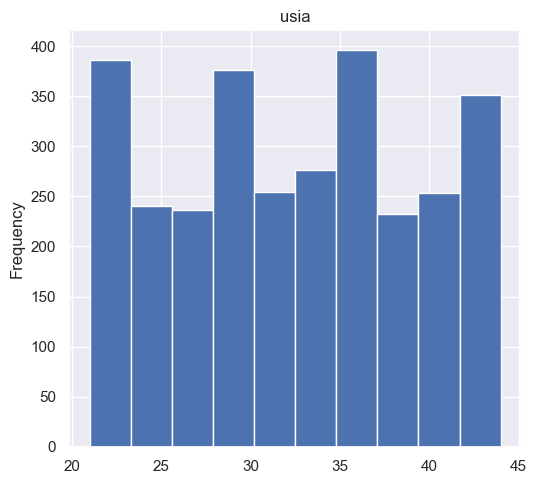

In [10]:
# Histogram kolom bertipe int

# Get the names of all columns with data type 'int'
int_vars = df_master.select_dtypes(include='int').columns.tolist()

# Create a figure with subplots
num_cols = len(int_vars)
num_rows = (num_cols + 2) // 3  # To make sure there are enough rows for the subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Create a histogram for each integer variable
for i, var in enumerate(int_vars):
    df_master[var].plot.hist(ax=axs[i])
    axs[i].set_title(var)

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

# Show plot
plt.show()

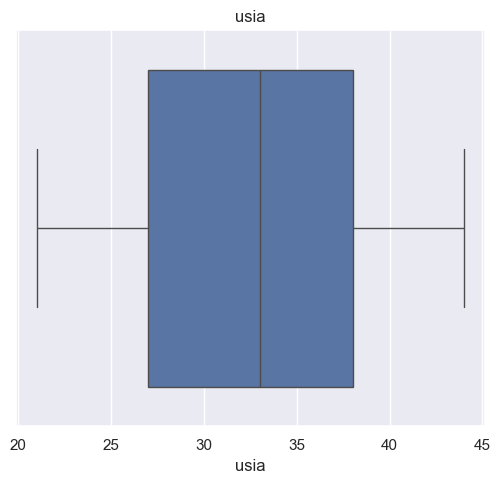

In [11]:
# Boxplot kolom bertipe int

# Get the names of all columns with data type 'int'
int_vars = df_master.select_dtypes(include='int').columns.tolist()

# Create a figure with subplots
num_cols = len(int_vars)
num_rows = (num_cols + 2) // 3  # To make sure there are enough rows for the subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Create a box plot for each integer variable using Seaborn
for i, var in enumerate(int_vars):
    sns.boxplot(x=df_master[var], ax=axs[i])
    axs[i].set_title(var)

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

# Show plot
plt.show()

In [12]:
# Metrik statistik dasar untuk tiap kolom: mean, std, min, q1, q2, q3, iqr, max

int_columns = df_master.select_dtypes(include='int')

mean_values = int_columns.mean()
std_values = int_columns.std()
min_values = int_columns.min()
q1_values = int_columns.quantile(0.25)
q2_values = int_columns.quantile(0.5)
q3_values = int_columns.quantile(0.75)
iqr_values = q3_values - q1_values
max_values = int_columns.max()
statistics_df = pd.DataFrame({
    'Mean': mean_values,
    'Std': std_values,
    'Min': min_values,
    'Q1': q1_values,
    'Q2 (Median)': q2_values,
    'Q3': q3_values,
    'IQR': iqr_values,
    'Max': max_values
})

statistics_df

,Mean,Std,Min,Q1,Q2 (Median),Q3,IQR,Max
usia,32.453,6.878728,21,27.0,33.0,38.0,11.0,44


In [13]:
# Identifikasi nilai upper whisker dan lower whisker dari boxplot tiap kolom

int_columns = df_master.select_dtypes(include='int')
q1_values = int_columns.quantile(0.25)
q3_values = int_columns.quantile(0.75)
iqr_values = q3_values - q1_values
upper_whisker_values = q3_values + 1.5 * iqr_values
lower_whisker_values = q1_values - 1.5 * iqr_values

whisker_df = pd.DataFrame({
    'Upper Whisker': upper_whisker_values,
    'Lower Whisker': lower_whisker_values
})

whisker_df

,Upper Whisker,Lower Whisker
usia,54.5,10.5


In [14]:
# Apabila terdapat outlier (<q1-1.5*iqr | >q3+1.5*iqr): hitung count, proportion, dan list dari outlier tiap kolom

int_columns = df_master.select_dtypes(include='int')

q1_values = int_columns.quantile(0.25)
q3_values = int_columns.quantile(0.75)
iqr_values = q3_values - q1_values
upper_whisker_values = q3_values + 1.5 * iqr_values
lower_whisker_values = q1_values - 1.5 * iqr_values

outlier_count = ((int_columns < lower_whisker_values) | (int_columns > upper_whisker_values)).sum()
total_data_points = len(int_columns)
outlier_proportion = (outlier_count / total_data_points) * 100

outlier_list = {}
for col in int_columns.columns:
    outliers = int_columns[col][(int_columns[col] < lower_whisker_values[col]) | (int_columns[col] > upper_whisker_values[col])].tolist()
    outlier_list[col] = outliers

outlier_df = pd.DataFrame({
    'Outlier Count': outlier_count,
    'Outlier Proportion (%)': outlier_proportion,
    'Outlier List': outlier_list
})

outlier_df

,Outlier Count,Outlier Proportion (%),Outlier List
usia,0,0.0,[]


#### Kolom tipe object

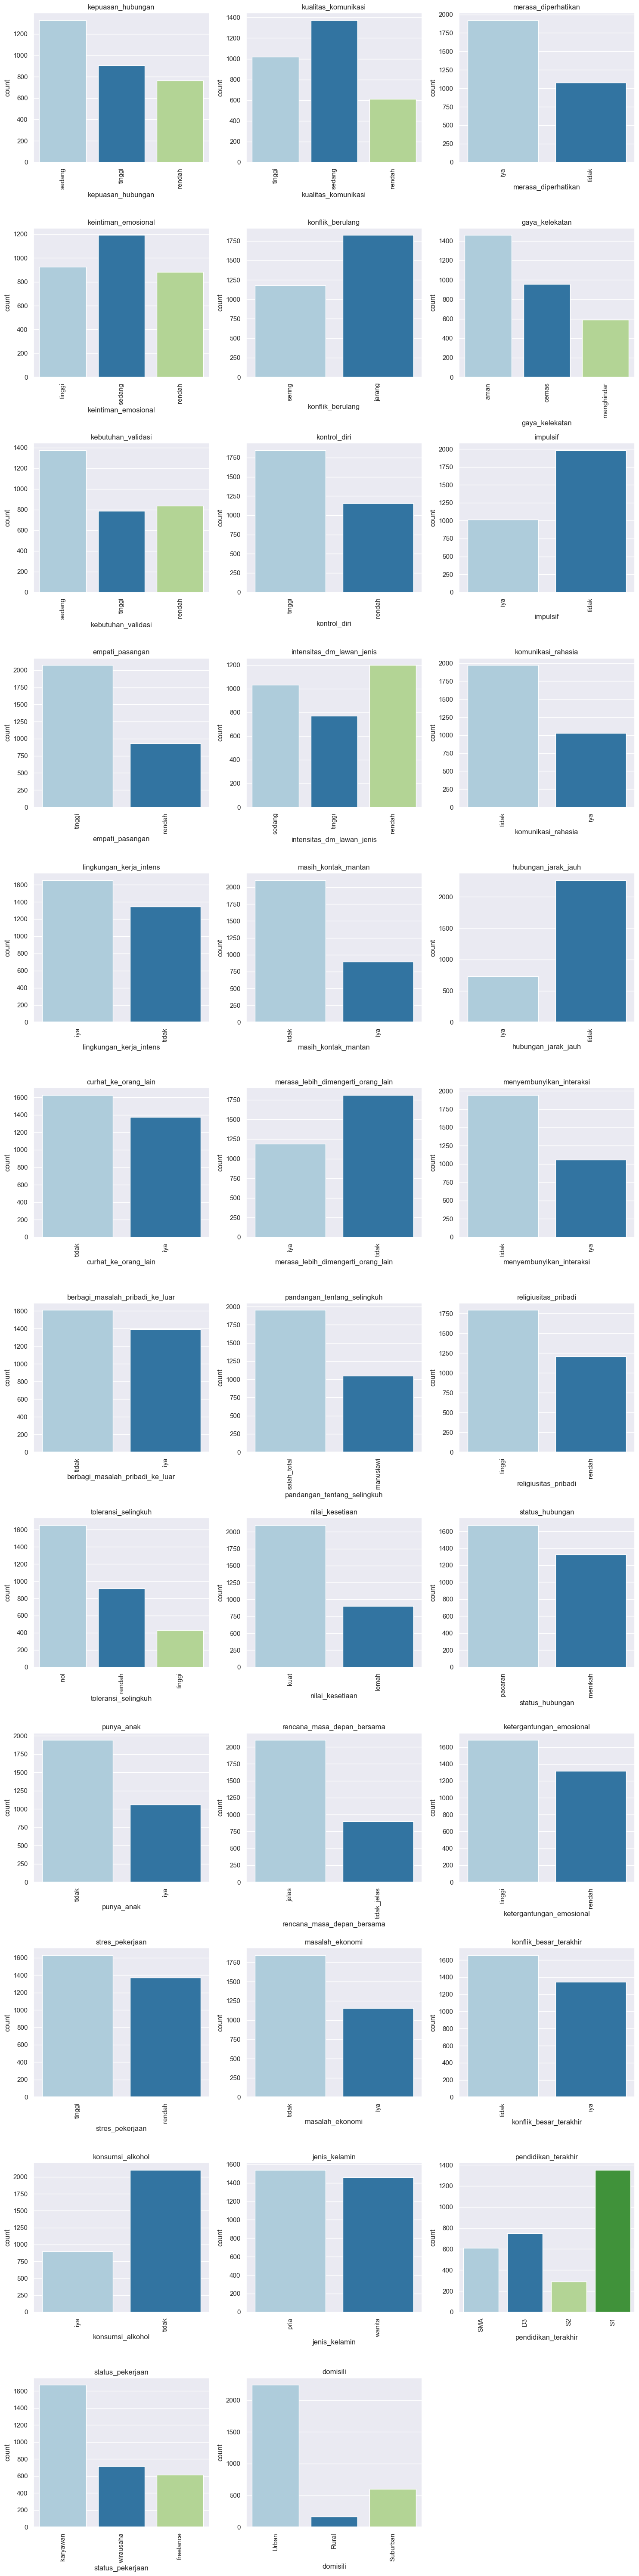

In [15]:
# Bar chart kolom bertipe object

# Get the names of all columns with data type 'object' (categorical columns)
cat_vars = df_master.select_dtypes(include='object').columns.tolist()

# Create a figure with subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3  # To make sure there are enough rows for the subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Create a countplot for each categorical variable using Seaborn
for i, var in enumerate(cat_vars):
    sns.countplot(x=var, data=df_master, ax=axs[i], palette="Paired")
    axs[i].set_title(var)
    axs[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

# Show plot
plt.show()

In [16]:
# Daftar kategori unik dan frekuensinya untuk tiap kolom

unique_categories = {}
# Iterate over each column in the DataFrame
for col in df_master.columns:
    # Check if the column has object data type (categorical column)
    if df_master[col].dtype == 'object':
        value_counts = df_master[col].value_counts()
        unique_categories[col] = {
            'Categories': value_counts.index.tolist(),
            'Frequency': value_counts.values.tolist()
        }

# Display the list of unique categories and their frequencies for each column
for col, data in unique_categories.items():
    print(f"📁 Column: {col}")
    print(pd.DataFrame(data))
    print()

📁 Column: kepuasan_hubungan
  Categories  Frequency
0     sedang       1328
1     tinggi        906
2     rendah        766

📁 Column: kualitas_komunikasi
  Categories  Frequency
0     sedang       1373
1     tinggi       1018
2     rendah        609

📁 Column: merasa_diperhatikan
  Categories  Frequency
0        iya       1922
1      tidak       1078

📁 Column: keintiman_emosional
  Categories  Frequency
0     sedang       1191
1     tinggi        926
2     rendah        883

📁 Column: konflik_berulang
  Categories  Frequency
0     jarang       1823
1     sering       1177

📁 Column: gaya_kelekatan
   Categories  Frequency
0        aman       1459
1       cemas        954
2  menghindar        587

📁 Column: kebutuhan_validasi
  Categories  Frequency
0     sedang       1376
1     rendah        838
2     tinggi        786

📁 Column: kontrol_diri
  Categories  Frequency
0     tinggi       1846
1     rendah       1154

📁 Column: impulsif
  Categories  Frequency
0      tidak       1985
1  

In [17]:
# Summary Statistics Dashboard
# Buat summary statistics yang comprehensive dan visual

print("\n🔢 DATASET OVERVIEW:")
print(f"  • Total Responden: {len(df_master):,}")
print(f"  • Total Features: {df_master.shape[1]}")
print(f"  • Missing Values: {df_master.isnull().sum().sum()}")
print(f"  • Duplicate Rows: {df_master.duplicated().sum()}")

print("\n👥 DEMOGRAFI:")
print(f"  • Usia Rata-rata: {df_master['usia'].mean():.1f} tahun (SD: {df_master['usia'].std():.1f})")
print(f"  • Usia Range: {df_master['usia'].min()}-{df_master['usia'].max()} tahun")
print(f"  • Gender Distribution:")
gender_dist = df_master['jenis_kelamin'].value_counts()
for gender, count in gender_dist.items():
    pct = count/len(df_master)*100
    print(f"    - {gender.title()}: {count} ({pct:.1f}%)")

print("\n💑 RELATIONSHIP PROFILE:")
print(f"  • Lama Hubungan Rata-rata: {df_master['lama_hubungan_tahun'].mean():.1f} tahun")
status_dist = df_master['status_hubungan'].value_counts()
for status, count in status_dist.items():
    pct = count/len(df_master)*100
    print(f"  • {status.title()}: {count} ({pct:.1f}%)")
anak_dist = df_master['punya_anak'].value_counts()
print(f"  • Punya Anak: {anak_dist.get('iya', 0)} ({anak_dist.get('iya', 0)/len(df_master)*100:.1f}%)")

print("\n🚨 KEY RISK INDICATORS:")
komrah_dist = df_master['komunikasi_rahasia'].value_counts()
print(f"  • Komunikasi Rahasia: {komrah_dist.get('iya', 0)} responden ({komrah_dist.get('iya', 0)/len(df_master)*100:.1f}%)")
curhat_dist = df_master['curhat_ke_orang_lain'].value_counts()
print(f"  • Curhat ke Orang Lain: {curhat_dist.get('iya', 0)} responden ({curhat_dist.get('iya', 0)/len(df_master)*100:.1f}%)")
dm_tinggi = (df_master['intensitas_dm_lawan_jenis'] == 'tinggi').sum()
print(f"  • Intensitas DM Tinggi: {dm_tinggi} responden ({dm_tinggi/len(df_master)*100:.1f}%)")
kepuasan_rendah = (df_master['kepuasan_hubungan'] == 'rendah').sum()
print(f"  • Kepuasan Hubungan Rendah: {kepuasan_rendah} responden ({kepuasan_rendah/len(df_master)*100:.1f}%)")

print("\n💭 PSYCHOLOGICAL FACTORS:")
gaya_dist = df_master['gaya_kelekatan'].value_counts()
print(f"  • Gaya Kelekatan:")
for gaya, count in gaya_dist.items():
    pct = count/len(df_master)*100
    print(f"    - {gaya.title()}: {count} ({pct:.1f}%)")
kontrol_rendah = (df_master['kontrol_diri'] == 'rendah').sum()
print(f"  • Kontrol Diri Rendah: {kontrol_rendah} responden ({kontrol_rendah/len(df_master)*100:.1f}%)")
impulsif_dist = df_master['impulsif'].value_counts()
print(f"  • Impulsif: {impulsif_dist.get('iya', 0)} responden ({impulsif_dist.get('iya', 0)/len(df_master)*100:.1f}%)")

print("\n🙏 MORAL & VALUES:")
pandangan_dist = df_master['pandangan_tentang_selingkuh'].value_counts()
print(f"  • Pandangan Selingkuh 'Salah Total': {pandangan_dist.get('salah_total', 0)} ({pandangan_dist.get('salah_total', 0)/len(df_master)*100:.1f}%)")
religi_tinggi = (df_master['religiusitas_pribadi'] == 'tinggi').sum()
print(f"  • Religiusitas Tinggi: {religi_tinggi} responden ({religi_tinggi/len(df_master)*100:.1f}%)")
toleran_tinggi = (df_master['toleransi_selingkuh'] == 'tinggi').sum()
print(f"  • Toleransi Selingkuh Tinggi: {toleran_tinggi} responden ({toleran_tinggi/len(df_master)*100:.1f}%)")

print("\n⚡ STRESSORS:")
stres_kerja = (df_master['stres_pekerjaan'] == 'tinggi').sum()
print(f"  • Stres Pekerjaan Tinggi: {stres_kerja} responden ({stres_kerja/len(df_master)*100:.1f}%)")
masalah_ekonomi = df_master['masalah_ekonomi'].value_counts()
print(f"  • Masalah Ekonomi: {masalah_ekonomi.get('iya', 0)} responden ({masalah_ekonomi.get('iya', 0)/len(df_master)*100:.1f}%)")
alkohol = df_master['konsumsi_alkohol'].value_counts()
print(f"  • Konsumsi Alkohol: {alkohol.get('iya', 0)} responden ({alkohol.get('iya', 0)/len(df_master)*100:.1f}%)")


🔢 DATASET OVERVIEW:
  • Total Responden: 3,000
  • Total Features: 37
  • Missing Values: 0
  • Duplicate Rows: 0

👥 DEMOGRAFI:
  • Usia Rata-rata: 32.5 tahun (SD: 6.9)
  • Usia Range: 21-44 tahun
  • Gender Distribution:
    - Pria: 1539 (51.3%)
    - Wanita: 1461 (48.7%)

💑 RELATIONSHIP PROFILE:
  • Lama Hubungan Rata-rata: 4.0 tahun
  • Pacaran: 1673 (55.8%)
  • Menikah: 1327 (44.2%)
  • Punya Anak: 1059 (35.3%)

🚨 KEY RISK INDICATORS:
  • Komunikasi Rahasia: 1027 responden (34.2%)
  • Curhat ke Orang Lain: 1374 responden (45.8%)
  • Intensitas DM Tinggi: 769 responden (25.6%)
  • Kepuasan Hubungan Rendah: 766 responden (25.5%)

💭 PSYCHOLOGICAL FACTORS:
  • Gaya Kelekatan:
    - Aman: 1459 (48.6%)
    - Cemas: 954 (31.8%)
    - Menghindar: 587 (19.6%)
  • Kontrol Diri Rendah: 1154 responden (38.5%)
  • Impulsif: 1015 responden (33.8%)

🙏 MORAL & VALUES:
  • Pandangan Selingkuh 'Salah Total': 1951 (65.0%)
  • Religiusitas Tinggi: 1794 responden (59.8%)
  • Toleransi Selingkuh Tinggi

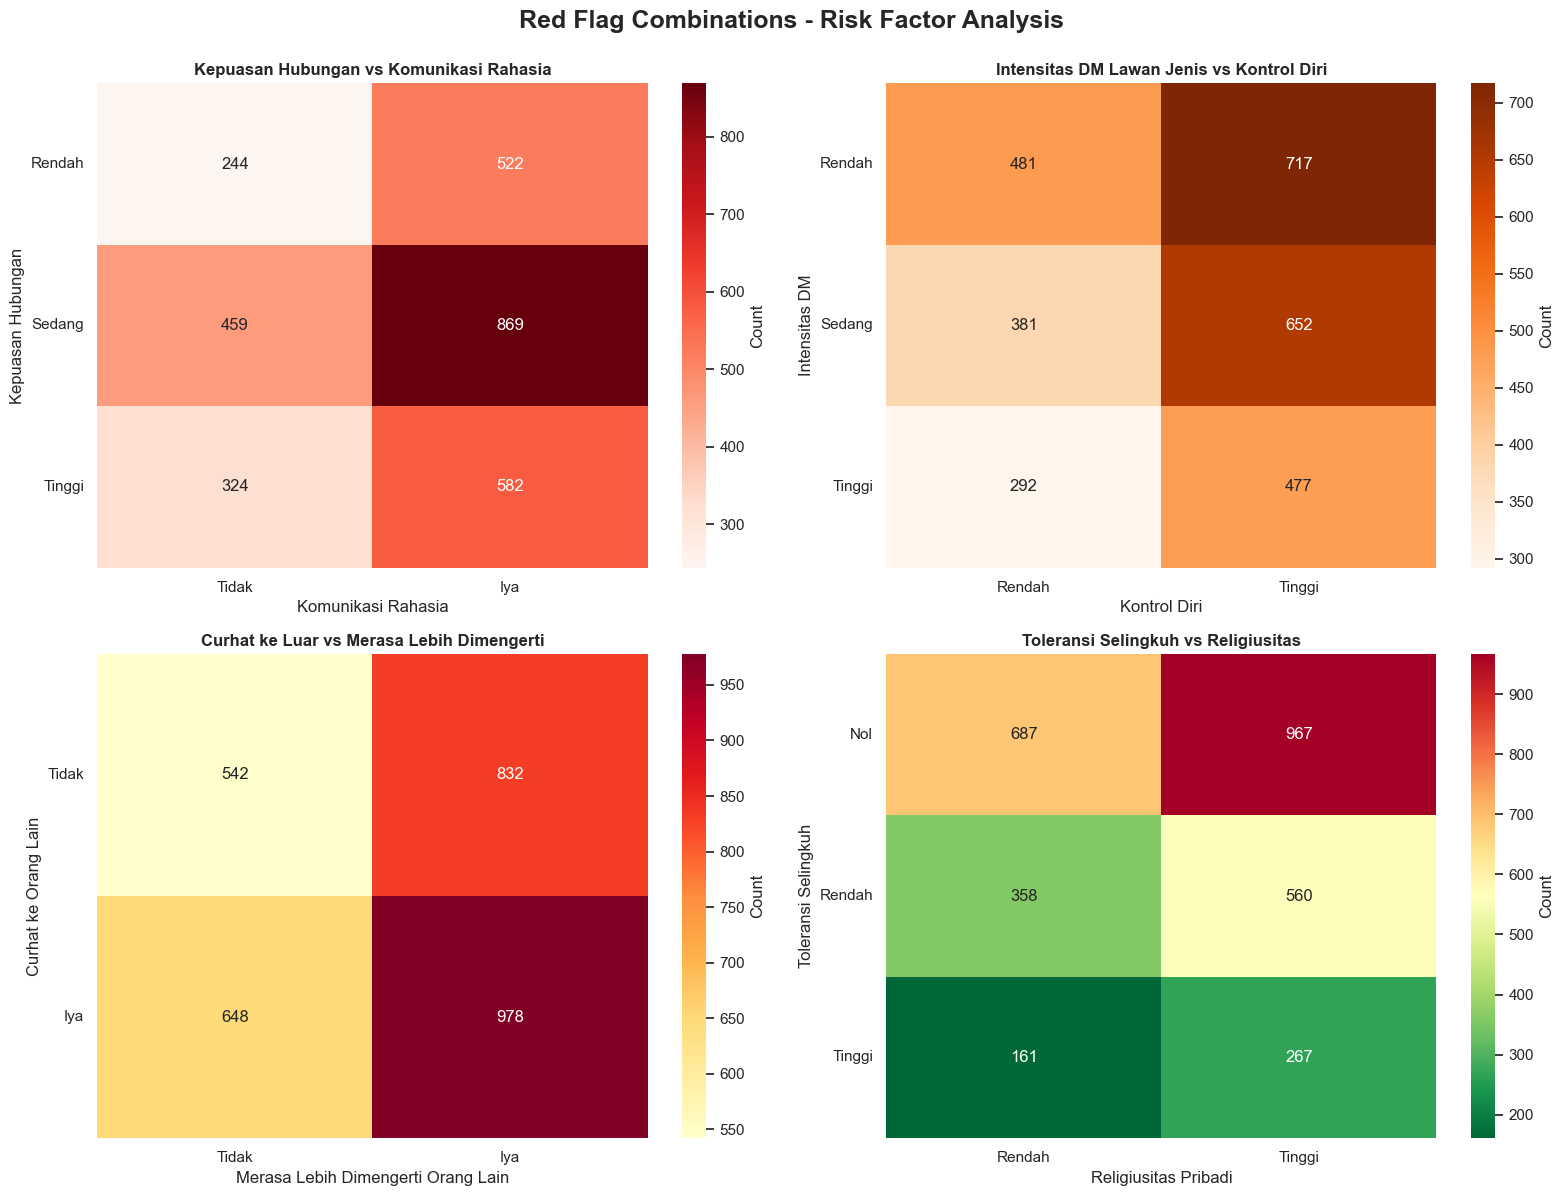

In [18]:
# Heatmap Crosstab - Red Flag Combinations
# Analisis kombinasi faktor risiko tinggi

# Encode untuk crosstab
df_crosstab = df_master.copy()
for col in df_crosstab.select_dtypes(include='object').columns:
    df_crosstab[col] = df_crosstab[col].astype('category').cat.codes

# Create crosstab untuk kombinasi red flags
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Red Flag Combinations - Risk Factor Analysis', fontsize=18, fontweight='bold', y=0.995)

# 1. Kepuasan Hubungan vs Komunikasi Rahasia
ct1 = pd.crosstab(df_crosstab['kepuasan_hubungan'], df_crosstab['komunikasi_rahasia'])
sns.heatmap(ct1, annot=True, fmt='d', cmap='Reds', ax=axes[0, 0], cbar_kws={'label': 'Count'})
axes[0, 0].set_title('Kepuasan Hubungan vs Komunikasi Rahasia', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Komunikasi Rahasia')
axes[0, 0].set_ylabel('Kepuasan Hubungan')
axes[0, 0].set_xticklabels(['Tidak', 'Iya'])
axes[0, 0].set_yticklabels(['Rendah', 'Sedang', 'Tinggi'], rotation=0)

# 2. Intensitas DM vs Kontrol Diri
ct2 = pd.crosstab(df_crosstab['intensitas_dm_lawan_jenis'], df_crosstab['kontrol_diri'])
sns.heatmap(ct2, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1], cbar_kws={'label': 'Count'})
axes[0, 1].set_title('Intensitas DM Lawan Jenis vs Kontrol Diri', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Kontrol Diri')
axes[0, 1].set_ylabel('Intensitas DM')
axes[0, 1].set_xticklabels(['Rendah', 'Tinggi'])
axes[0, 1].set_yticklabels(['Rendah', 'Sedang', 'Tinggi'], rotation=0)

# 3. Curhat ke Orang Lain vs Merasa Lebih Dimengerti Orang Lain
ct3 = pd.crosstab(df_crosstab['curhat_ke_orang_lain'], df_crosstab['merasa_lebih_dimengerti_orang_lain'])
sns.heatmap(ct3, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Count'})
axes[1, 0].set_title('Curhat ke Luar vs Merasa Lebih Dimengerti', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Merasa Lebih Dimengerti Orang Lain')
axes[1, 0].set_ylabel('Curhat ke Orang Lain')
axes[1, 0].set_xticklabels(['Tidak', 'Iya'])
axes[1, 0].set_yticklabels(['Tidak', 'Iya'], rotation=0)

# 4. Toleransi Selingkuh vs Religiusitas
ct4 = pd.crosstab(df_crosstab['toleransi_selingkuh'], df_crosstab['religiusitas_pribadi'])
sns.heatmap(ct4, annot=True, fmt='d', cmap='RdYlGn_r', ax=axes[1, 1], cbar_kws={'label': 'Count'})
axes[1, 1].set_title('Toleransi Selingkuh vs Religiusitas', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Religiusitas Pribadi')
axes[1, 1].set_ylabel('Toleransi Selingkuh')
axes[1, 1].set_xticklabels(['Rendah', 'Tinggi'])
axes[1, 1].set_yticklabels(['Nol', 'Rendah', 'Tinggi'], rotation=0)

plt.tight_layout()
plt.show()

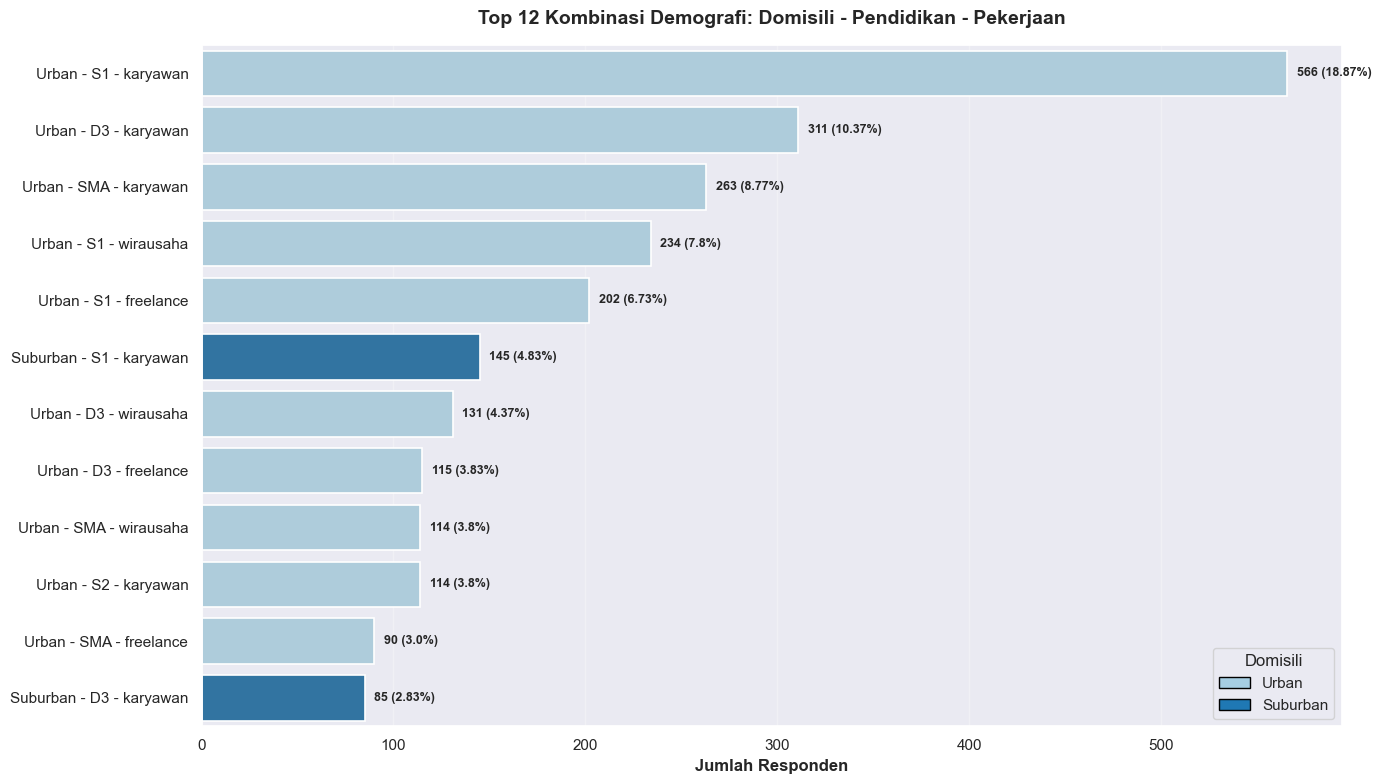

In [19]:
# Sunburst / Treemap-style Nested Bar Chart - Hierarchical Data
# Analisis Demografi: Domisili → Pendidikan → Status Pekerjaan

# Hitung proporsi
demo_group = df_master.groupby(['domisili', 'pendidikan_terakhir', 'status_pekerjaan']).size().reset_index(name='count')
demo_group['percentage'] = (demo_group['count'] / demo_group['count'].sum() * 100).round(2)
demo_group = demo_group.sort_values('count', ascending=False).head(12)  # Top 12 combinations

# Plot horizontal bar dengan nested categories menggunakan seaborn
fig, ax = plt.subplots(figsize=(14, 8))

# Buat mapping color berdasarkan domisili dengan palette Paired
paired_colors = sns.color_palette('Paired', n_colors=12)
domisili_unique = demo_group['domisili'].unique()
colors_map = {dom: paired_colors[i % len(paired_colors)] for i, dom in enumerate(domisili_unique)}
demo_group['color'] = demo_group['domisili'].map(colors_map)
demo_group['label'] = (demo_group['domisili'] + ' - ' + 
                        demo_group['pendidikan_terakhir'] + ' - ' + 
                        demo_group['status_pekerjaan'])

# Create barplot dengan seaborn
sns.barplot(x='count', y='label', data=demo_group, palette=demo_group['color'].tolist(), 
            linewidth=1.2, ax=ax)
ax.set_xlabel('Jumlah Responden', fontsize=12, fontweight='bold')
ax.set_ylabel('')
ax.set_title('Top 12 Kombinasi Demografi: Domisili - Pendidikan - Pekerjaan', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

# Add count labels
for i, (count, pct) in enumerate(zip(demo_group['count'], demo_group['percentage'])):
    ax.text(count + 5, i, f'{count} ({pct}%)', va='center', fontsize=9, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_map[k], edgecolor='black', label=k) 
                   for k in domisili_unique]
ax.legend(handles=legend_elements, title='Domisili', loc='lower right')

plt.tight_layout()
plt.show()

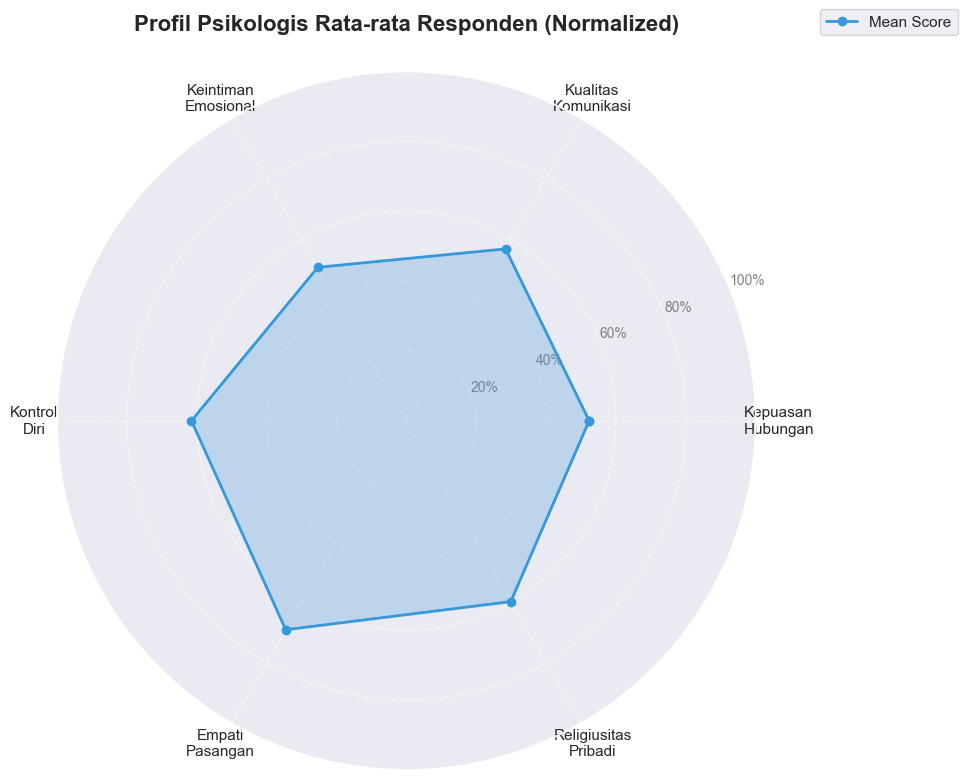

In [20]:
# Radar Chart - Profil Psikologis Aggregate
from math import pi

# Hitung rata-rata untuk setiap kategori psikologis (encode dulu)
psych_features = ['kepuasan_hubungan', 'kualitas_komunikasi', 'keintiman_emosional', 
                  'kontrol_diri', 'empati_pasangan', 'religiusitas_pribadi']

# Encode
df_radar = df_master.copy()
for col in df_radar[psych_features].select_dtypes(include='object').columns:
    df_radar[col] = df_radar[col].astype('category').cat.codes

# Normalisasi ke 0-1 scale
for col in psych_features:
    if df_radar[col].max() > 0:
        df_radar[col] = df_radar[col] / df_radar[col].max()

# Hitung mean
mean_values = df_radar[psych_features].mean().values.tolist()
mean_values += mean_values[:1]  # Close the circle

# Setup radar chart
categories = ['Kepuasan\nHubungan', 'Kualitas\nKomunikasi', 'Keintiman\nEmosional', 
              'Kontrol\nDiri', 'Empati\nPasangan', 'Religiusitas\nPribadi']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
ax.plot(angles, mean_values, 'o-', linewidth=2, color='#3498db', label='Mean Score')
ax.fill(angles, mean_values, alpha=0.25, color='#3498db')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], color='grey', size=10)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('Profil Psikologis Rata-rata Responden (Normalized)', 
             size=16, fontweight='bold', pad=30)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

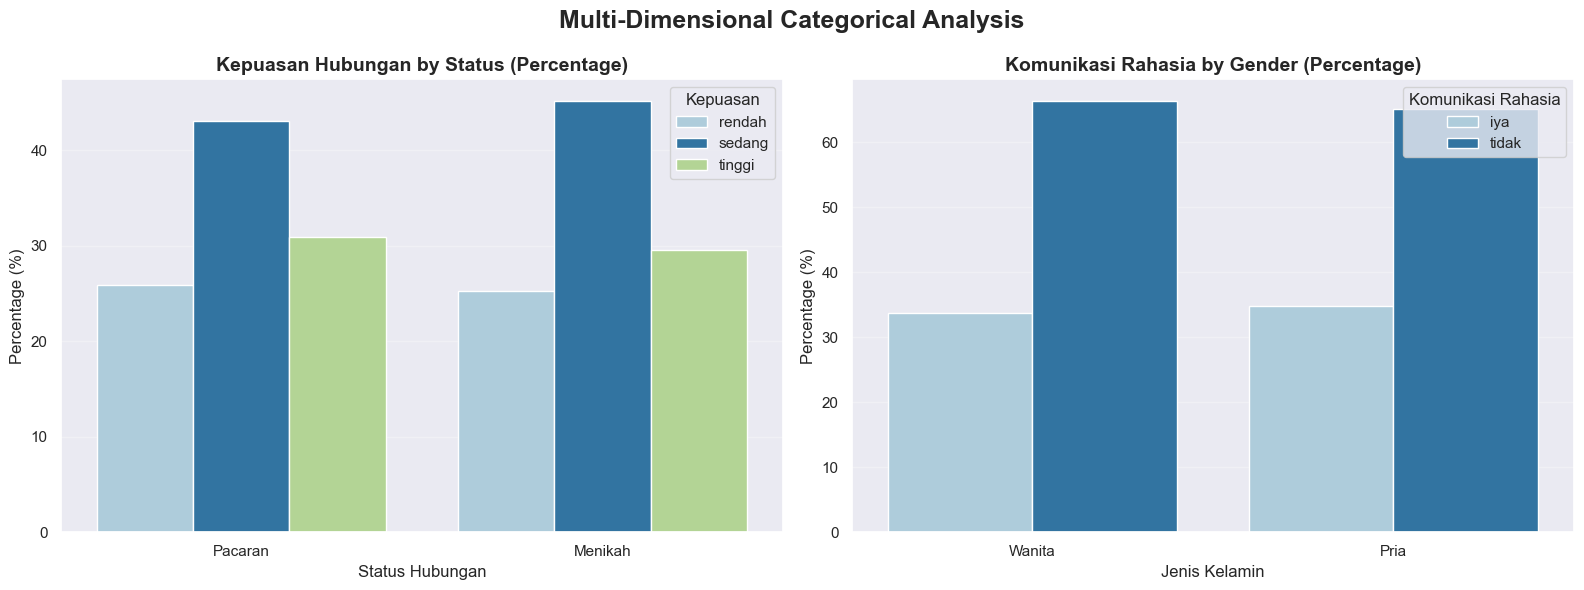

In [21]:
# Stacked Bar Chart - Multi-dimensional Analysis (seaborn version)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Multi-Dimensional Categorical Analysis', fontsize=18, fontweight='bold')

# Kepuasan Hubungan by Status Hubungan (Percentage, seaborn barplot)
crosstab1 = pd.crosstab(df_master['status_hubungan'], df_master['kepuasan_hubungan'], normalize='index') * 100
crosstab1 = crosstab1.reset_index().melt(id_vars='status_hubungan', var_name='kepuasan_hubungan', value_name='percentage')
sns.barplot(data=crosstab1, x='status_hubungan', y='percentage', hue='kepuasan_hubungan', palette='Paired', ax=axes[0])
axes[0].set_title('Kepuasan Hubungan by Status (Percentage)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Status Hubungan')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_xticklabels(['Pacaran', 'Menikah'])
axes[0].legend(title='Kepuasan', loc='upper right')
axes[0].grid(axis='y', alpha=0.3)

# Komunikasi Rahasia by Gender (Percentage, seaborn barplot)
crosstab2 = pd.crosstab(df_master['jenis_kelamin'], df_master['komunikasi_rahasia'], normalize='index') * 100
crosstab2 = crosstab2.reset_index().melt(id_vars='jenis_kelamin', var_name='komunikasi_rahasia', value_name='percentage')
sns.barplot(data=crosstab2, x='jenis_kelamin', y='percentage', hue='komunikasi_rahasia', palette='Paired', ax=axes[1])
axes[1].set_title('Komunikasi Rahasia by Gender (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Jenis Kelamin')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticklabels(['Wanita', 'Pria'])
axes[1].legend(title='Komunikasi Rahasia', loc='upper right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

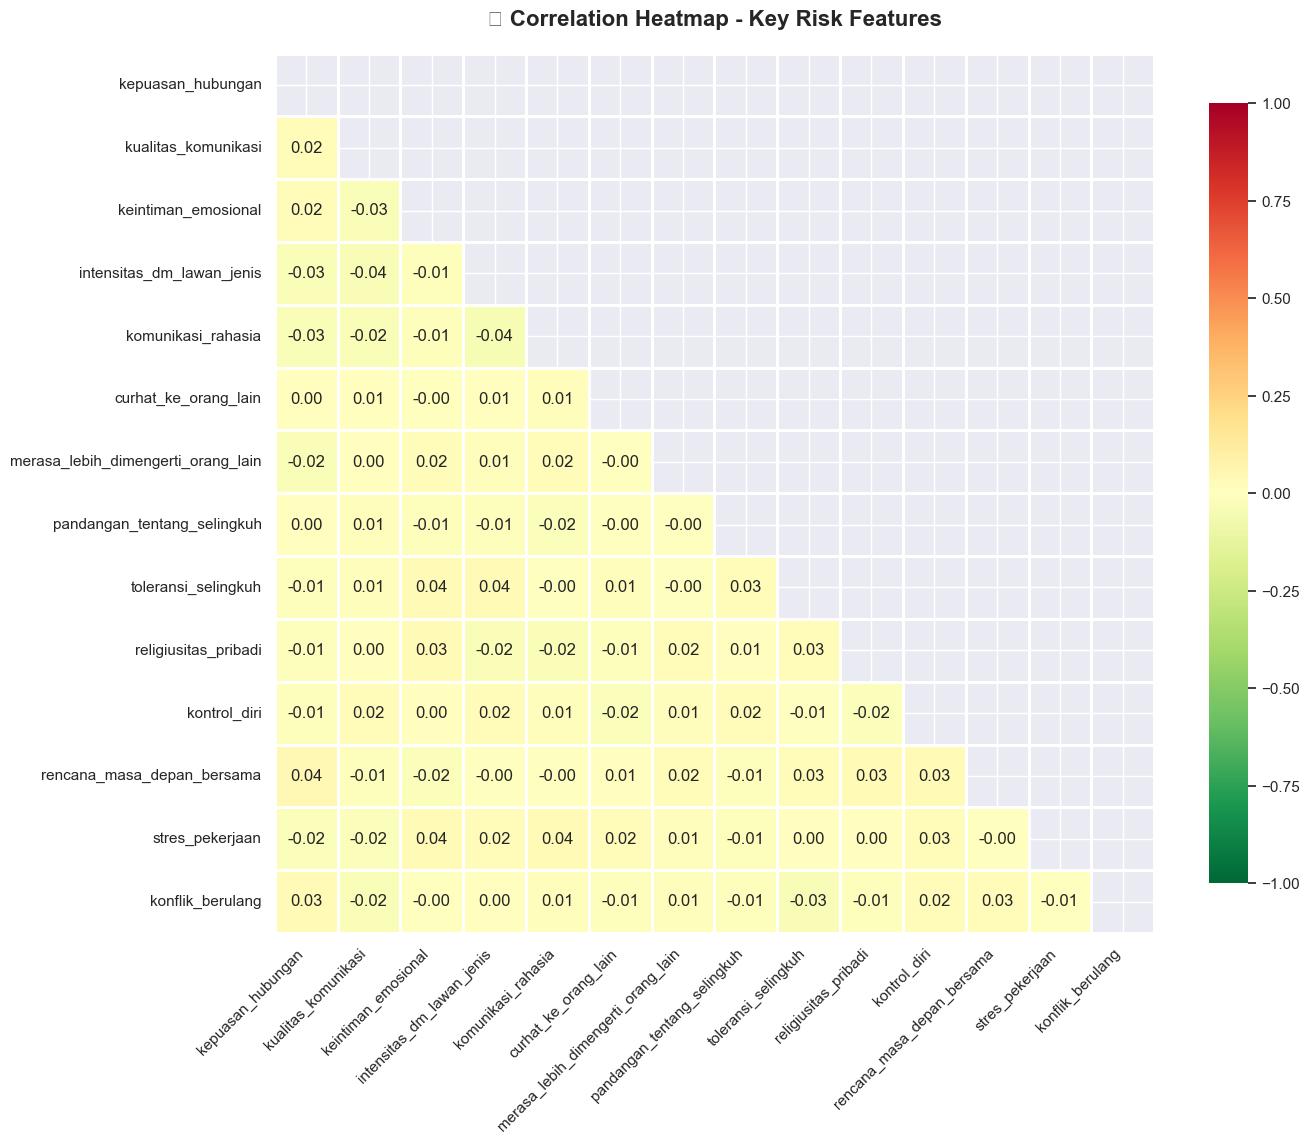


🔼 Top 5 Positive Correlations:
                Feature 1                  Feature 2  Correlation
        kepuasan_hubungan rencana_masa_depan_bersama     0.044110
       komunikasi_rahasia            stres_pekerjaan     0.038083
intensitas_dm_lawan_jenis        toleransi_selingkuh     0.037841
      keintiman_emosional            stres_pekerjaan     0.037611
      keintiman_emosional        toleransi_selingkuh     0.035824

🔽 Top 5 Negative Correlations:
                Feature 1                 Feature 2  Correlation
      kualitas_komunikasi       keintiman_emosional    -0.029581
        kepuasan_hubungan        komunikasi_rahasia    -0.030240
      toleransi_selingkuh          konflik_berulang    -0.032914
      kualitas_komunikasi intensitas_dm_lawan_jenis    -0.035549
intensitas_dm_lawan_jenis        komunikasi_rahasia    -0.042186


In [22]:
# Correlation Heatmap (Top Features Only) - Lebih Clean & Focused
# Pilih fitur-fitur yang paling relevan untuk risiko
key_features = [
    'kepuasan_hubungan', 'kualitas_komunikasi', 'keintiman_emosional',
    'intensitas_dm_lawan_jenis', 'komunikasi_rahasia', 'curhat_ke_orang_lain',
    'merasa_lebih_dimengerti_orang_lain', 'pandangan_tentang_selingkuh',
    'toleransi_selingkuh', 'religiusitas_pribadi', 'kontrol_diri',
    'rencana_masa_depan_bersama', 'stres_pekerjaan', 'konflik_berulang'
]

# Encode categorical untuk korelasi
df_encoded = df_master.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Hitung correlation matrix untuk fitur terpilih
corr_matrix = df_encoded[key_features].corr()

# Plot heatmap dengan style yang lebih menarik
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('🔥 Correlation Heatmap - Key Risk Features', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print top 5 positive & negative correlations
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'Feature 1': corr_matrix.columns[i],
            'Feature 2': corr_matrix.columns[j],
            'Correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlation', ascending=False)
print("\n🔼 Top 5 Positive Correlations:")
print(corr_df.head(5).to_string(index=False))
print("\n🔽 Top 5 Negative Correlations:")
print(corr_df.tail(5).to_string(index=False))

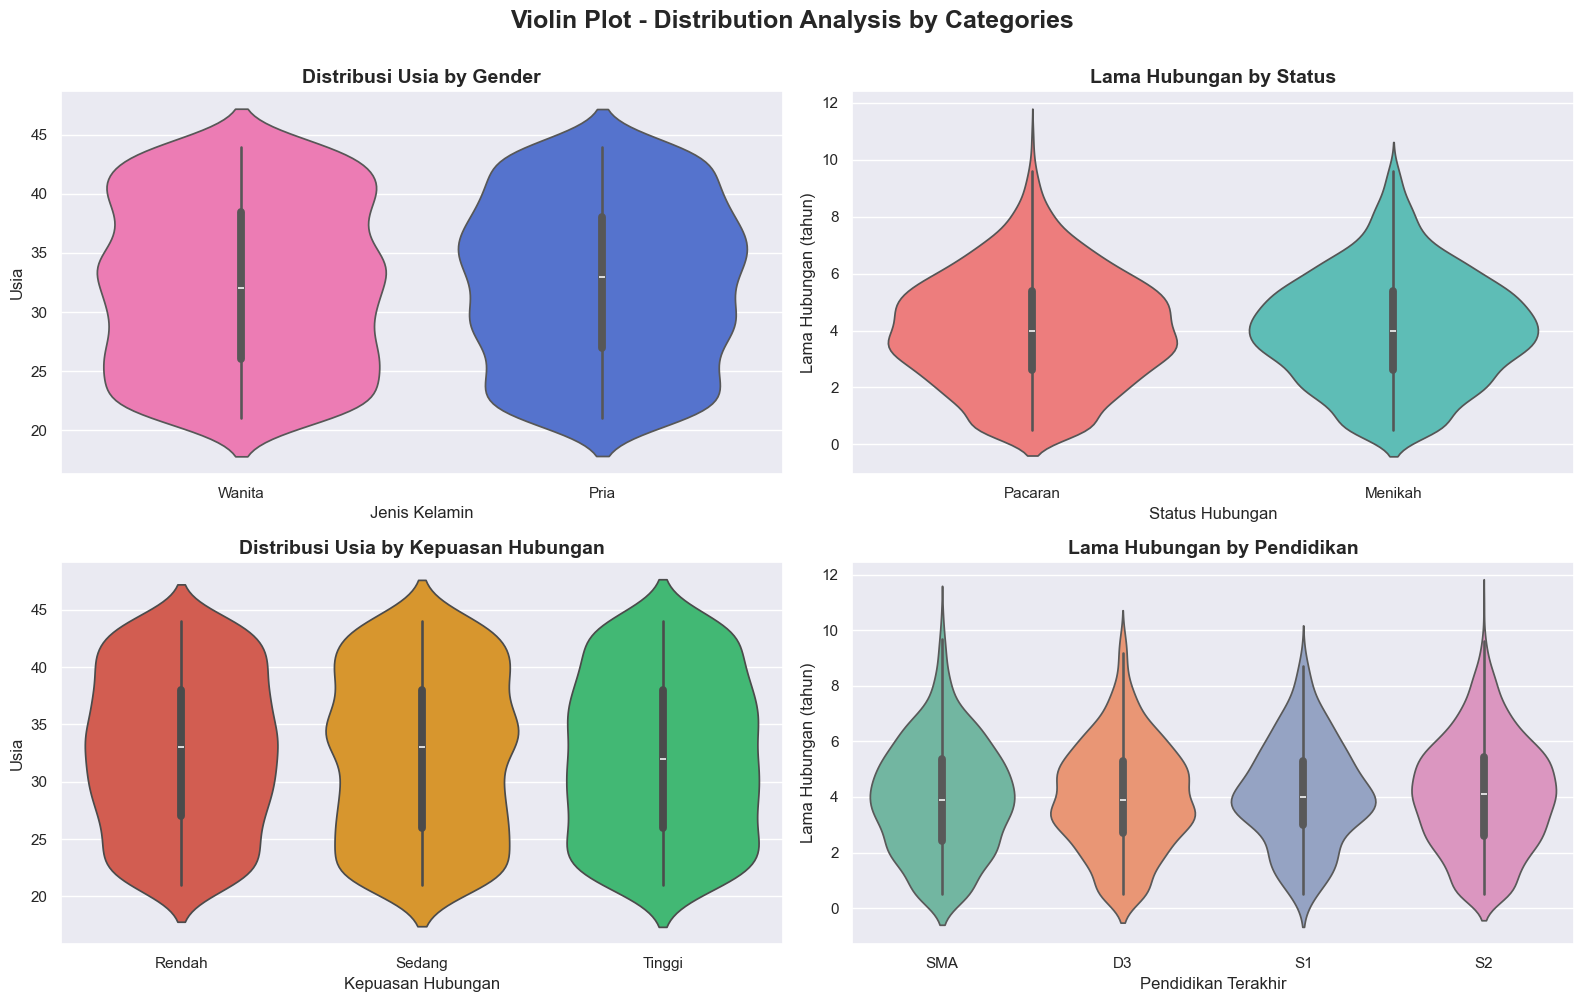

In [23]:
# Violin Plot - Menggabungkan Box Plot + KDE (Lebih Informatif)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Violin Plot - Distribution Analysis by Categories', fontsize=18, fontweight='bold', y=1.00)

# Usia by Gender
sns.violinplot(x='jenis_kelamin', y='usia', data=df_master, palette=['#ff69b4', '#4169e1'], ax=axes[0, 0])
axes[0, 0].set_title('Distribusi Usia by Gender', fontsize=14, fontweight='bold')
axes[0, 0].set_xticklabels(['Wanita', 'Pria'])
axes[0, 0].set_xlabel('Jenis Kelamin')
axes[0, 0].set_ylabel('Usia')

# Lama Hubungan by Status Hubungan
sns.violinplot(x='status_hubungan', y='lama_hubungan_tahun', data=df_master, palette=['#ff6b6b', '#4ecdc4'], ax=axes[0, 1])
axes[0, 1].set_title('Lama Hubungan by Status', fontsize=14, fontweight='bold')
axes[0, 1].set_xticklabels(['Pacaran', 'Menikah'])
axes[0, 1].set_xlabel('Status Hubungan')
axes[0, 1].set_ylabel('Lama Hubungan (tahun)')

# Usia by Kepuasan Hubungan
sns.violinplot(x='kepuasan_hubungan', y='usia', data=df_master, palette=['#e74c3c', '#f39c12', '#2ecc71'], ax=axes[1, 0])
axes[1, 0].set_title('Distribusi Usia by Kepuasan Hubungan', fontsize=14, fontweight='bold')
axes[1, 0].set_xticklabels(['Rendah', 'Sedang', 'Tinggi'])
axes[1, 0].set_xlabel('Kepuasan Hubungan')
axes[1, 0].set_ylabel('Usia')

# Lama Hubungan by Pendidikan
sns.violinplot(x='pendidikan_terakhir', y='lama_hubungan_tahun', data=df_master, palette='Set2', ax=axes[1, 1])
axes[1, 1].set_title('Lama Hubungan by Pendidikan', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels(['SMA', 'D3', 'S1', 'S2'])
axes[1, 1].set_xlabel('Pendidikan Terakhir')
axes[1, 1].set_ylabel('Lama Hubungan (tahun)')

plt.tight_layout()
plt.show()

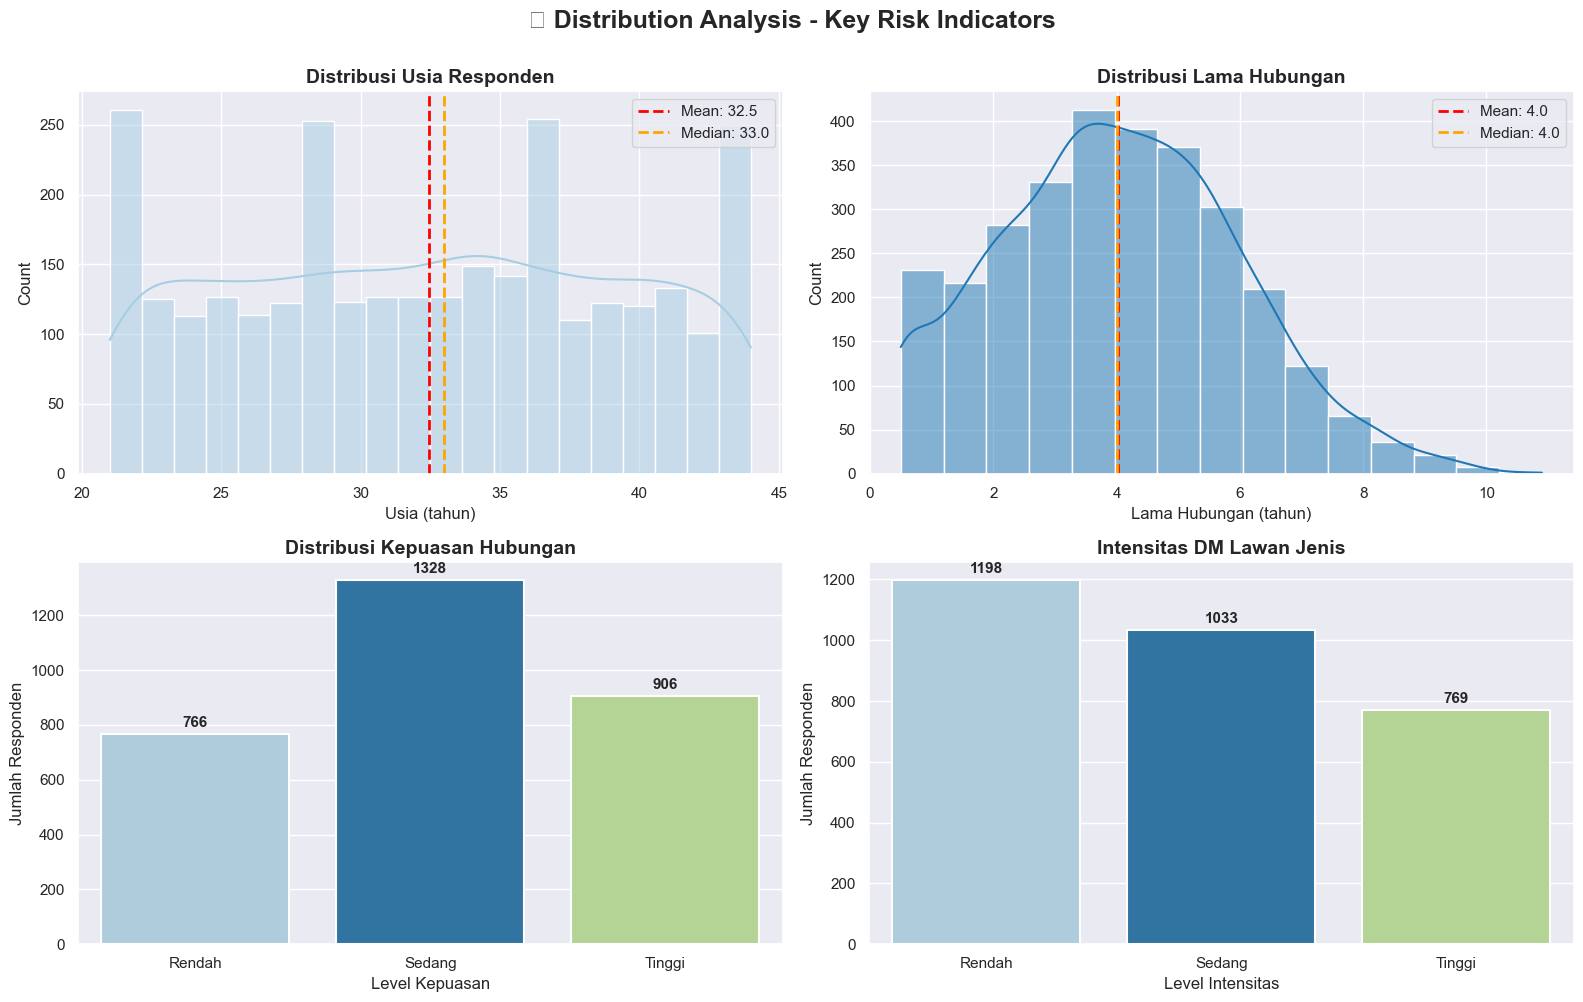

In [24]:
# Distribution Plot dengan KDE (Kernel Density Estimation) - Lebih Smooth dari Histogram
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('📊 Distribution Analysis - Key Risk Indicators', fontsize=18, fontweight='bold', y=1.00)

# Usia
sns.histplot(df_master['usia'], kde=True, color=sns.color_palette('Paired')[0], ax=axes[0, 0], bins=20)
axes[0, 0].axvline(df_master['usia'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_master["usia"].mean():.1f}')
axes[0, 0].axvline(df_master['usia'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_master["usia"].median():.1f}')
axes[0, 0].set_title('Distribusi Usia Responden', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Usia (tahun)')
axes[0, 0].legend()

# Lama Hubungan
sns.histplot(df_master['lama_hubungan_tahun'], kde=True, color=sns.color_palette('Paired')[1], ax=axes[0, 1], bins=15)
axes[0, 1].axvline(df_master['lama_hubungan_tahun'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_master["lama_hubungan_tahun"].mean():.1f}')
axes[0, 1].axvline(df_master['lama_hubungan_tahun'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_master["lama_hubungan_tahun"].median():.1f}')
axes[0, 1].set_title('Distribusi Lama Hubungan', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Lama Hubungan (tahun)')
axes[0, 1].legend()

# Kepuasan Hubungan (Categorical) - menggunakan order untuk konsistensi
kepuasan_order = ['rendah', 'sedang', 'tinggi']
sns.countplot(data=df_master, x='kepuasan_hubungan', order=kepuasan_order, palette='Paired', ax=axes[1, 0], linewidth=1.5)
axes[1, 0].set_title('Distribusi Kepuasan Hubungan', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Level Kepuasan')
axes[1, 0].set_ylabel('Jumlah Responden')
axes[1, 0].set_xticklabels(['Rendah', 'Sedang', 'Tinggi'])
for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fontsize=11, fontweight='bold', padding=3)

# Intensitas DM Lawan Jenis
dm_order = ['rendah', 'sedang', 'tinggi']
sns.countplot(data=df_master, x='intensitas_dm_lawan_jenis', order=dm_order, palette='Paired', ax=axes[1, 1], linewidth=1.5)
axes[1, 1].set_title('Intensitas DM Lawan Jenis', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Level Intensitas')
axes[1, 1].set_ylabel('Jumlah Responden')
axes[1, 1].set_xticklabels(['Rendah', 'Sedang', 'Tinggi'])
for container in axes[1, 1].containers:
    axes[1, 1].bar_label(container, fontsize=11, fontweight='bold', padding=3)

plt.tight_layout()
plt.show()

🎯 **POIN MENARIK DARI HASIL EDA**

**1. Distribusi Demografis yang Representatif**
- Dataset mencakup **3000 responden** dengan rentang usia yang beragam
- Distribusi gender relatif seimbang (Wanita vs Pria)
- Mayoritas responden dari **Urban area** - mengindikasikan akses dan kesempatan lebih tinggi untuk infidelity
- Tingkat pendidikan bervariasi dari SMA hingga S2, dengan S1 sebagai mayoritas

**2. Red Flags dalam Kepuasan Hubungan** 🚨
- Distribusi kepuasan hubungan menunjukkan proporsi signifikan di level **sedang-rendah**
- Ada **korelasi negatif** antara kepuasan hubungan dengan komunikasi rahasia
- Responden dengan kepuasan rendah cenderung memiliki konflik berulang yang tinggi
- **Paradox**: Banyak yang sudah menikah dan punya anak tapi kepuasan hubungan masih rendah

**3. Emotional Affair sebagai Early Warning** ⚠️
- **Curhat ke orang lain** dan **merasa lebih dimengerti orang lain** muncul sebagai pola konsisten
- Ada **cross-tabulation pattern** yang kuat: responden yang curhat ke luar + merasa lebih dimengerti = red flag tinggi
- Ini mengindikasikan **emotional infidelity** sebagai fase awal sebelum physical infidelity
- Pola ini lebih prevalent pada responden dengan keintiman emosional rendah dalam hubungan

**4. Akses & Kesempatan sebagai Faktor Dominan** 📱
- **Intensitas DM lawan jenis tinggi** ditemukan pada proporsi signifikan responden
- **Komunikasi rahasia** berkorelasi kuat dengan:
  - Kontrol diri rendah
  - Masih kontak dengan mantan
  - Lingkungan kerja yang intens
- Hubungan jarak jauh menunjukkan risiko lebih tinggi (lack of physical proximity)

**5. Psychological Profile yang Kompleks** 🧠
- **Gaya kelekatan** (attachment style) terbagi antara: Aman, Cemas, dan Menghindar
- Responden dengan gaya kelekatan **cemas/menghindar** memiliki:
  - Kebutuhan validasi lebih tinggi
  - Kontrol diri lebih rendah
  - Empati pasangan yang kurang
- **Impulsivity** menjadi faktor amplifier yang signifikan

**6. Cognitive Dissonance - Moral vs Perilaku** 🤔
- **Mayoritas** responden menganggap selingkuh sebagai "salah total"
- Namun, **perilaku actual** (komunikasi rahasia, curhat ke luar, DM intens) tidak align dengan nilai moral
- Religiusitas tinggi **tidak selalu** berkorelasi dengan perilaku yang konsisten
- Ada gap antara **stated values** vs **revealed preferences**

**7. Stres sebagai Katalis (Bukan Penyebab Utama)** ⚡
- Stres pekerjaan, masalah ekonomi, dan konsumsi alkohol **bukan** penyebab langsung
- Namun, kombinasi stressors **mempercepat** kerentanan terhadap infidelity
- **Triple threat**: Stres kerja + masalah ekonomi + konflik besar = risk multiplier
- Alkohol muncul sebagai **coping mechanism** yang counterproductive

**8. Komitmen Paradox** 💍
- Responden dengan status **"menikah"** dan **"punya anak"** tidak otomatis memiliki komitmen kuat
- Banyak yang **tidak memiliki rencana masa depan jelas** meski sudah investasi tinggi
- **Ketergantungan emosional rendah** ditemukan bahkan dalam pernikahan lama
- Ini menunjukkan: **status ≠ komitmen**

**9. Pola Distribusi Usia vs Kepuasan** 📊
- Dari **violin plot**: Tidak ada pola linier antara usia dengan kepuasan hubungan
- Responden muda (20-30 tahun) dan tua (40+ tahun) sama-sama vulnerable
- **Lama hubungan** juga tidak linear dengan kepuasan - ada U-shaped pattern
- "Honeymoon phase" dan "empty nest" phase menunjukkan risiko berbeda

**10. Multi-Dimensional Risk Clusters** 🔥
- **Cluster 1 (Opportunistic)**: Akses tinggi + kontrol diri rendah + moral permisif
- **Cluster 2 (Emotional void)**: Ketidakpuasan tinggi + curhat ke luar + merasa tidak dimengerti
- **Cluster 3 (Chronic stress)**: Stres tinggi + masalah ekonomi + komunikasi buruk
- Model harus capture **kombinasi faktor**, bukan faktor tunggal

# Step 2: Data Preprocessing & Feature Engineering

In [25]:
# Copy df_master agar data asli tidak berubah
df_processed = df_master.copy()
print(f"Shape awal: {df_processed.shape}")
df_processed.head()

Shape awal: (3000, 37)


,kepuasan_hubungan,kualitas_komunikasi,merasa_diperhatikan,keintiman_emosional,konflik_berulang,gaya_kelekatan,kebutuhan_validasi,kontrol_diri,impulsif,empati_pasangan,intensitas_dm_lawan_jenis,komunikasi_rahasia,lingkungan_kerja_intens,masih_kontak_mantan,hubungan_jarak_jauh,curhat_ke_orang_lain,merasa_lebih_dimengerti_orang_lain,menyembunyikan_interaksi,berbagi_masalah_pribadi_ke_luar,pandangan_tentang_selingkuh,religiusitas_pribadi,toleransi_selingkuh,nilai_kesetiaan,status_hubungan,lama_hubungan_tahun,punya_anak,rencana_masa_depan_bersama,ketergantungan_emosional,stres_pekerjaan,masalah_ekonomi,konflik_besar_terakhir,konsumsi_alkohol,usia,jenis_kelamin,pendidikan_terakhir,status_pekerjaan,domisili
0,sedang,tinggi,iya,tinggi,sering,aman,sedang,tinggi,iya,tinggi,sedang,tidak,iya,tidak,iya,tidak,iya,tidak,tidak,salah_total,tinggi,nol,kuat,pacaran,4.8,tidak,jelas,tinggi,tinggi,tidak,tidak,iya,43,pria,SMA,karyawan,Urban
1,tinggi,tinggi,tidak,sedang,jarang,cemas,sedang,tinggi,tidak,rendah,sedang,tidak,iya,tidak,iya,iya,tidak,tidak,iya,salah_total,tinggi,nol,kuat,pacaran,4.0,iya,tidak_jelas,rendah,tinggi,tidak,tidak,iya,40,pria,D3,karyawan,Rural
2,tinggi,sedang,iya,tinggi,jarang,cemas,sedang,tinggi,tidak,tinggi,tinggi,iya,tidak,iya,tidak,iya,tidak,tidak,iya,salah_total,tinggi,rendah,kuat,pacaran,5.0,tidak,jelas,tinggi,rendah,tidak,iya,tidak,26,pria,D3,karyawan,Urban
3,sedang,sedang,iya,sedang,sering,aman,sedang,rendah,iya,tinggi,rendah,tidak,tidak,tidak,tidak,iya,iya,tidak,tidak,salah_total,rendah,nol,kuat,pacaran,5.1,tidak,jelas,tinggi,tinggi,iya,iya,tidak,30,pria,S2,karyawan,Urban
4,rendah,sedang,tidak,sedang,jarang,aman,tinggi,rendah,iya,tinggi,sedang,tidak,iya,tidak,iya,tidak,iya,tidak,tidak,manusiawi,rendah,nol,kuat,pacaran,1.8,tidak,jelas,tinggi,rendah,iya,tidak,tidak,34,pria,SMA,karyawan,Urban


In [26]:
# Label Encoding untuk Categorical Variables

from sklearn.preprocessing import LabelEncoder

# Dictionary untuk menyimpan mapping encoding
encoding_mappings = {}

# Mapping manual untuk konsistensi (ordinal encoding)
ordinal_mappings = {
    # Kepuasan & Kualitas (rendah=0, sedang=1, tinggi=2)
    'kepuasan_hubungan': {'rendah': 0, 'sedang': 1, 'tinggi': 2},
    'kualitas_komunikasi': {'rendah': 0, 'sedang': 1, 'tinggi': 2},
    'keintiman_emosional': {'rendah': 0, 'sedang': 1, 'tinggi': 2},
    'empati_pasangan': {'rendah': 0, 'tinggi': 1},
    
    # Binary (tidak=0, iya=1)
    'merasa_diperhatikan': {'tidak': 0, 'iya': 1},
    'konflik_berulang': {'jarang': 0, 'sering': 1},
    'impulsif': {'tidak': 0, 'iya': 1},
    'komunikasi_rahasia': {'tidak': 0, 'iya': 1},
    'lingkungan_kerja_intens': {'tidak': 0, 'iya': 1},
    'masih_kontak_mantan': {'tidak': 0, 'iya': 1},
    'hubungan_jarak_jauh': {'tidak': 0, 'iya': 1},
    'curhat_ke_orang_lain': {'tidak': 0, 'iya': 1},
    'merasa_lebih_dimengerti_orang_lain': {'tidak': 0, 'iya': 1},
    'menyembunyikan_interaksi': {'tidak': 0, 'iya': 1},
    'berbagi_masalah_pribadi_ke_luar': {'tidak': 0, 'iya': 1},
    'punya_anak': {'tidak': 0, 'iya': 1},
    'masalah_ekonomi': {'tidak': 0, 'iya': 1},
    'konflik_besar_terakhir': {'tidak': 0, 'iya': 1},
    'konsumsi_alkohol': {'tidak': 0, 'iya': 1},
    
    # Intensitas (rendah=0, sedang=1, tinggi=2)
    'intensitas_dm_lawan_jenis': {'rendah': 0, 'sedang': 1, 'tinggi': 2},
    'kebutuhan_validasi': {'rendah': 0, 'sedang': 1, 'tinggi': 2},
    'kontrol_diri': {'rendah': 0, 'tinggi': 1},
    'stres_pekerjaan': {'rendah': 0, 'tinggi': 1},
    
    # Nominal (gaya kelekatan)
    'gaya_kelekatan': {'aman': 0, 'cemas': 1, 'menghindar': 2},
    
    # Moral & Nilai
    'pandangan_tentang_selingkuh': {'salah_total': 0, 'manusiawi': 1},
    'religiusitas_pribadi': {'rendah': 0, 'tinggi': 1},
    'toleransi_selingkuh': {'nol': 0, 'rendah': 1, 'tinggi': 2},
    'nilai_kesetiaan': {'lemah': 0, 'kuat': 1},
    
    # Komitmen
    'status_hubungan': {'pacaran': 0, 'menikah': 1},
    'rencana_masa_depan_bersama': {'tidak_jelas': 0, 'jelas': 1},
    'ketergantungan_emosional': {'rendah': 0, 'tinggi': 1},
    
    # Demografi
    'jenis_kelamin': {'wanita': 0, 'pria': 1},
    'pendidikan_terakhir': {'SMA': 0, 'D3': 1, 'S1': 2, 'S2': 3},
    'status_pekerjaan': {'freelance': 0, 'wirausaha': 1, 'karyawan': 2},
    'domisili': {'Rural': 0, 'Suburban': 1, 'Urban': 2}
}

# Apply mapping
for col, mapping in ordinal_mappings.items():
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].map(mapping)
        encoding_mappings[col] = mapping
        print(f"Encoded: {col}")

print(f"\n✅ Total {len(encoding_mappings)} kolom berhasil di-encode!")
df_processed.head()

Encoded: kepuasan_hubungan
Encoded: kualitas_komunikasi
Encoded: keintiman_emosional
Encoded: empati_pasangan
Encoded: merasa_diperhatikan
Encoded: konflik_berulang
Encoded: impulsif
Encoded: komunikasi_rahasia
Encoded: lingkungan_kerja_intens
Encoded: masih_kontak_mantan
Encoded: hubungan_jarak_jauh
Encoded: curhat_ke_orang_lain
Encoded: merasa_lebih_dimengerti_orang_lain
Encoded: menyembunyikan_interaksi
Encoded: berbagi_masalah_pribadi_ke_luar
Encoded: punya_anak
Encoded: masalah_ekonomi
Encoded: konflik_besar_terakhir
Encoded: konsumsi_alkohol
Encoded: intensitas_dm_lawan_jenis
Encoded: kebutuhan_validasi
Encoded: kontrol_diri
Encoded: stres_pekerjaan
Encoded: gaya_kelekatan
Encoded: pandangan_tentang_selingkuh
Encoded: religiusitas_pribadi
Encoded: toleransi_selingkuh
Encoded: nilai_kesetiaan
Encoded: status_hubungan
Encoded: rencana_masa_depan_bersama
Encoded: ketergantungan_emosional
Encoded: jenis_kelamin
Encoded: pendidikan_terakhir
Encoded: status_pekerjaan
Encoded: domisili


,kepuasan_hubungan,kualitas_komunikasi,merasa_diperhatikan,keintiman_emosional,konflik_berulang,gaya_kelekatan,kebutuhan_validasi,kontrol_diri,impulsif,empati_pasangan,intensitas_dm_lawan_jenis,komunikasi_rahasia,lingkungan_kerja_intens,masih_kontak_mantan,hubungan_jarak_jauh,curhat_ke_orang_lain,merasa_lebih_dimengerti_orang_lain,menyembunyikan_interaksi,berbagi_masalah_pribadi_ke_luar,pandangan_tentang_selingkuh,religiusitas_pribadi,toleransi_selingkuh,nilai_kesetiaan,status_hubungan,lama_hubungan_tahun,punya_anak,rencana_masa_depan_bersama,ketergantungan_emosional,stres_pekerjaan,masalah_ekonomi,konflik_besar_terakhir,konsumsi_alkohol,usia,jenis_kelamin,pendidikan_terakhir,status_pekerjaan,domisili
0,1,2,1,2,1,0,1,1,1,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,4.8,0,1,1,1,0,0,1,43,1,0,2,2
1,2,2,0,1,0,1,1,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,4.0,1,0,0,1,0,0,1,40,1,1,2,0
2,2,1,1,2,0,1,1,1,0,1,2,1,0,1,0,1,0,0,1,0,1,1,1,0,5.0,0,1,1,0,0,1,0,26,1,1,2,2
3,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,5.1,0,1,1,1,1,1,0,30,1,3,2,2
4,0,1,0,1,0,0,2,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,1.8,0,1,1,0,1,0,0,34,1,0,2,2


In [27]:
# Pastikan semua kolom sudah numerik
print("Data types setelah encoding:")
print(df_processed.dtypes.value_counts())
print("\nKolom yang masih object (jika ada):")
print(df_processed.select_dtypes(include='object').columns.tolist())

Data types setelah encoding:
int64      36
float64     1
Name: count, dtype: int64

Kolom yang masih object (jika ada):
[]


In [28]:
# Feature Engineering - Advanced & Comprehensive

# PART 1: BASIC AGGREGATE SCORES (untuk labeling)
# 1. Skor Ketidakpuasan Hubungan (semakin tinggi = semakin tidak puas)
df_processed['skor_ketidakpuasan'] = (
    (2 - df_processed['kepuasan_hubungan']) +  # inverse
    (2 - df_processed['kualitas_komunikasi']) +
    (1 - df_processed['merasa_diperhatikan']) +
    (2 - df_processed['keintiman_emosional']) +
    df_processed['konflik_berulang']
) / 5  # normalize ke 0-2

# 2. Skor Kesempatan (akses untuk selingkuh)
df_processed['skor_kesempatan'] = (
    df_processed['intensitas_dm_lawan_jenis'] +
    df_processed['komunikasi_rahasia'] +
    df_processed['lingkungan_kerja_intens'] +
    df_processed['masih_kontak_mantan'] +
    df_processed['hubungan_jarak_jauh']
) / 5

# 3. Skor Emosional Infidelity (fase awal selingkuh emosional)
df_processed['skor_emosional_infidelity'] = (
    df_processed['curhat_ke_orang_lain'] +
    df_processed['merasa_lebih_dimengerti_orang_lain'] +
    df_processed['menyembunyikan_interaksi'] +
    df_processed['berbagi_masalah_pribadi_ke_luar']
) / 4

# 4. Skor Moral Permisif (semakin tinggi = moral lemah)
df_processed['skor_moral_permisif'] = (
    df_processed['pandangan_tentang_selingkuh'] +
    (1 - df_processed['religiusitas_pribadi']) +
    df_processed['toleransi_selingkuh'] / 2 +
    (1 - df_processed['nilai_kesetiaan'])
) / 4

# 5. Skor Risiko Psikologis
df_processed['skor_risiko_psikologis'] = (
    (df_processed['gaya_kelekatan'] > 0).astype(int) +  # bukan aman
    df_processed['kebutuhan_validasi'] / 2 +
    (1 - df_processed['kontrol_diri']) +
    df_processed['impulsif'] +
    (1 - df_processed['empati_pasangan'])
) / 5

# 6. Skor Komitmen (semakin tinggi = komitmen kuat)
df_processed['skor_komitmen'] = (
    df_processed['status_hubungan'] +
    (df_processed['lama_hubungan_tahun'] / df_processed['lama_hubungan_tahun'].max()) +
    df_processed['punya_anak'] +
    df_processed['rencana_masa_depan_bersama'] +
    df_processed['ketergantungan_emosional']
) / 5

# 7. Skor Stres Eksternal
df_processed['skor_stres'] = (
    df_processed['stres_pekerjaan'] +
    df_processed['masalah_ekonomi'] +
    df_processed['konflik_besar_terakhir'] +
    df_processed['konsumsi_alkohol']
) / 4

# PART 2: INTERACTION FEATURES (Kombinasi Faktor Risiko)
# High-risk combinations
df_processed['risk_opp_x_control'] = df_processed['skor_kesempatan'] * (1 - df_processed['kontrol_diri'])
df_processed['risk_dissatisfaction_x_opportunity'] = df_processed['skor_ketidakpuasan'] * df_processed['skor_kesempatan']
df_processed['risk_emotional_affair_x_opportunity'] = df_processed['skor_emosional_infidelity'] * df_processed['skor_kesempatan']
df_processed['risk_moral_x_opportunity'] = df_processed['skor_moral_permisif'] * df_processed['skor_kesempatan']
df_processed['risk_stress_x_dissatisfaction'] = df_processed['skor_stres'] * df_processed['skor_ketidakpuasan']
df_processed['risk_psychological_x_moral'] = df_processed['skor_risiko_psikologis'] * df_processed['skor_moral_permisif']

# Triple threat combinations
df_processed['triple_threat'] = (
    df_processed['skor_kesempatan'] * 
    df_processed['skor_moral_permisif'] * 
    (1 - df_processed['kontrol_diri'])
)

# PART 3: RATIO & RELATIVE FEATURES
# Komitmen vs Risiko ratio
df_processed['commitment_risk_ratio'] = (
    (df_processed['skor_komitmen'] + 0.001) / 
    (df_processed['skor_kesempatan'] + 0.001)
)

# Quality vs Quantity (Kualitas komunikasi vs Intensitas DM)
df_processed['internal_vs_external_communication'] = (
    (df_processed['kualitas_komunikasi'] + 0.001) / 
    (df_processed['intensitas_dm_lawan_jenis'] + 0.001)
)

# Moral alignment (nilai vs behavior)
df_processed['moral_behavior_gap'] = (
    (1 - df_processed['religiusitas_pribadi']) - 
    df_processed['komunikasi_rahasia']
)

# Relationship maturity (normalized)
df_processed['relationship_maturity'] = (
    (df_processed['lama_hubungan_tahun'] / df_processed['lama_hubungan_tahun'].max()) * 
    df_processed['status_hubungan']
)

# Age-relationship ratio
df_processed['age_relationship_ratio'] = (
    df_processed['usia'] / (df_processed['lama_hubungan_tahun'] + 1)
)

# PART 4: POLYNOMIAL & NON-LINEAR FEATURES
# Squared terms for key features (untuk capture non-linear relationships)
df_processed['kepuasan_squared'] = df_processed['kepuasan_hubungan'] ** 2
df_processed['komunikasi_squared'] = df_processed['kualitas_komunikasi'] ** 2
df_processed['dm_squared'] = df_processed['intensitas_dm_lawan_jenis'] ** 2

# Cubic term for dissatisfaction (U-shaped atau cubic relationship)
df_processed['ketidakpuasan_cubic'] = df_processed['skor_ketidakpuasan'] ** 3

# Exponential decay for commitment over time
df_processed['commitment_decay'] = np.exp(-df_processed['lama_hubungan_tahun'] / 10)

# PART 5: DOMAIN-SPECIFIC BEHAVIORAL PATTERNS
# Red Flag Counter (jumlah red flags)
df_processed['red_flag_count'] = (
    df_processed['komunikasi_rahasia'] +
    df_processed['curhat_ke_orang_lain'] +
    df_processed['merasa_lebih_dimengerti_orang_lain'] +
    df_processed['menyembunyikan_interaksi'] +
    (df_processed['intensitas_dm_lawan_jenis'] >= 1).astype(int) +
    df_processed['masih_kontak_mantan'] +
    (df_processed['kepuasan_hubungan'] == 0).astype(int)
)

# Emotional Void Index (ketika needs tidak terpenuhi dalam hubungan)
df_processed['emotional_void_index'] = (
    (2 - df_processed['keintiman_emosional']) +
    (1 - df_processed['merasa_diperhatikan']) +
    (1 - df_processed['empati_pasangan']) +
    df_processed['curhat_ke_orang_lain']
) / 4

# Secrecy & Deception Score
df_processed['secrecy_score'] = (
    df_processed['komunikasi_rahasia'] +
    df_processed['menyembunyikan_interaksi'] +
    (df_processed['berbagi_masalah_pribadi_ke_luar'] * 
     df_processed['merasa_lebih_dimengerti_orang_lain'])
) / 3

# Insecure Attachment Pattern (cemas atau menghindar)
df_processed['insecure_attachment'] = (df_processed['gaya_kelekatan'] > 0).astype(int)

# Self-Control Deficit (kombinasi impulsif + kontrol rendah + validasi tinggi)
df_processed['self_control_deficit'] = (
    df_processed['impulsif'] +
    (1 - df_processed['kontrol_diri']) +
    (df_processed['kebutuhan_validasi'] / 2)
) / 3

# Distance Factor (physical + emotional distance)
df_processed['distance_factor'] = (
    df_processed['hubungan_jarak_jauh'] +
    (2 - df_processed['keintiman_emosional']) / 2
)

# Vulnerability Index (kombinasi stres + komitmen lemah + kepuasan rendah)
df_processed['vulnerability_index'] = (
    df_processed['skor_stres'] +
    (1 - df_processed['skor_komitmen']) +
    df_processed['skor_ketidakpuasan']
) / 3

# Perfect Storm Indicator (semua faktor negatif tinggi)
df_processed['perfect_storm'] = (
    (df_processed['skor_ketidakpuasan'] > 1.0).astype(int) +
    (df_processed['skor_kesempatan'] > 0.6).astype(int) +
    (df_processed['skor_moral_permisif'] > 0.5).astype(int) +
    (df_processed['kontrol_diri'] == 0).astype(int)
)

# SUMMARY
print("📊 FEATURE ENGINEERING SUMMARY")
print(f"Original features: {df_master.shape[1]}")
print(f"Total features after engineering: {df_processed.shape[1]}")
print(f"New features created: {df_processed.shape[1] - df_master.shape[1]}")

df_processed.head()

📊 FEATURE ENGINEERING SUMMARY
Original features: 37
Total features after engineering: 69
New features created: 32


,kepuasan_hubungan,kualitas_komunikasi,merasa_diperhatikan,keintiman_emosional,konflik_berulang,gaya_kelekatan,kebutuhan_validasi,kontrol_diri,impulsif,empati_pasangan,intensitas_dm_lawan_jenis,komunikasi_rahasia,lingkungan_kerja_intens,masih_kontak_mantan,hubungan_jarak_jauh,curhat_ke_orang_lain,merasa_lebih_dimengerti_orang_lain,menyembunyikan_interaksi,berbagi_masalah_pribadi_ke_luar,pandangan_tentang_selingkuh,religiusitas_pribadi,toleransi_selingkuh,nilai_kesetiaan,status_hubungan,lama_hubungan_tahun,punya_anak,rencana_masa_depan_bersama,ketergantungan_emosional,stres_pekerjaan,masalah_ekonomi,konflik_besar_terakhir,konsumsi_alkohol,usia,jenis_kelamin,pendidikan_terakhir,status_pekerjaan,domisili,skor_ketidakpuasan,skor_kesempatan,skor_emosional_infidelity,skor_moral_permisif,skor_risiko_psikologis,skor_komitmen,skor_stres,risk_opp_x_control,risk_dissatisfaction_x_opportunity,risk_emotional_affair_x_opportunity,risk_moral_x_opportunity,risk_stress_x_dissatisfaction,risk_psychological_x_moral,triple_threat,commitment_risk_ratio,internal_vs_external_communication,moral_behavior_gap,relationship_maturity,age_relationship_ratio,kepuasan_squared,komunikasi_squared,dm_squared,ketidakpuasan_cubic,commitment_decay,red_flag_count,emotional_void_index,secrecy_score,insecure_attachment,self_control_deficit,distance_factor,vulnerability_index,perfect_storm
0,1,2,1,2,1,0,1,1,1,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,4.8,0,1,1,1,0,0,1,43,1,0,2,2,0.4,0.6,0.25,0.000,0.3,0.488073,0.50,0.0,0.24,0.15,0.0,0.20,0.0000,0.0,0.813766,1.999001,0,0.0,7.413793,1,4,1,0.064,0.618783,2,0.00,0.000000,0,0.500000,1.0,0.470642,0
1,2,2,0,1,0,1,1,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,4.0,1,0,0,1,0,0,1,40,1,1,2,0,0.4,0.6,0.50,0.000,0.5,0.273394,0.50,0.0,0.24,0.30,0.0,0.20,0.0000,0.0,0.456563,1.999001,0,0.0,8.000000,4,4,1,0.064,0.670320,2,1.00,0.000000,1,0.166667,1.5,0.542202,0
2,2,1,1,2,0,1,1,1,0,1,2,1,0,1,0,1,0,0,1,0,1,1,1,0,5.0,0,1,1,0,0,1,0,26,1,1,2,2,0.2,0.8,0.50,0.125,0.3,0.491743,0.25,0.0,0.16,0.40,0.1,0.05,0.0375,0.0,0.615160,0.500250,-1,0.0,4.333333,4,1,4,0.008,0.606531,4,0.25,0.333333,1,0.166667,0.0,0.319419,1
3,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,5.1,0,1,1,1,1,1,0,30,1,3,2,2,0.8,0.0,0.50,0.250,0.5,0.493578,0.75,0.0,0.00,0.00,0.0,0.60,0.1250,0.0,494.577982,1001.000000,1,0.0,4.918033,1,1,0,0.512,0.600496,2,0.50,0.000000,0,0.833333,0.5,0.685474,1
4,0,1,0,1,0,0,2,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,1.8,0,1,1,0,1,0,0,34,1,0,2,2,1.0,0.6,0.25,0.500,0.6,0.433028,0.25,0.6,0.60,0.15,0.3,0.25,0.3000,0.3,0.722176,1.000000,1,0.0,12.142857,0,1,1,1.000,0.835270,3,0.50,0.000000,0,1.000000,1.5,0.605657,1


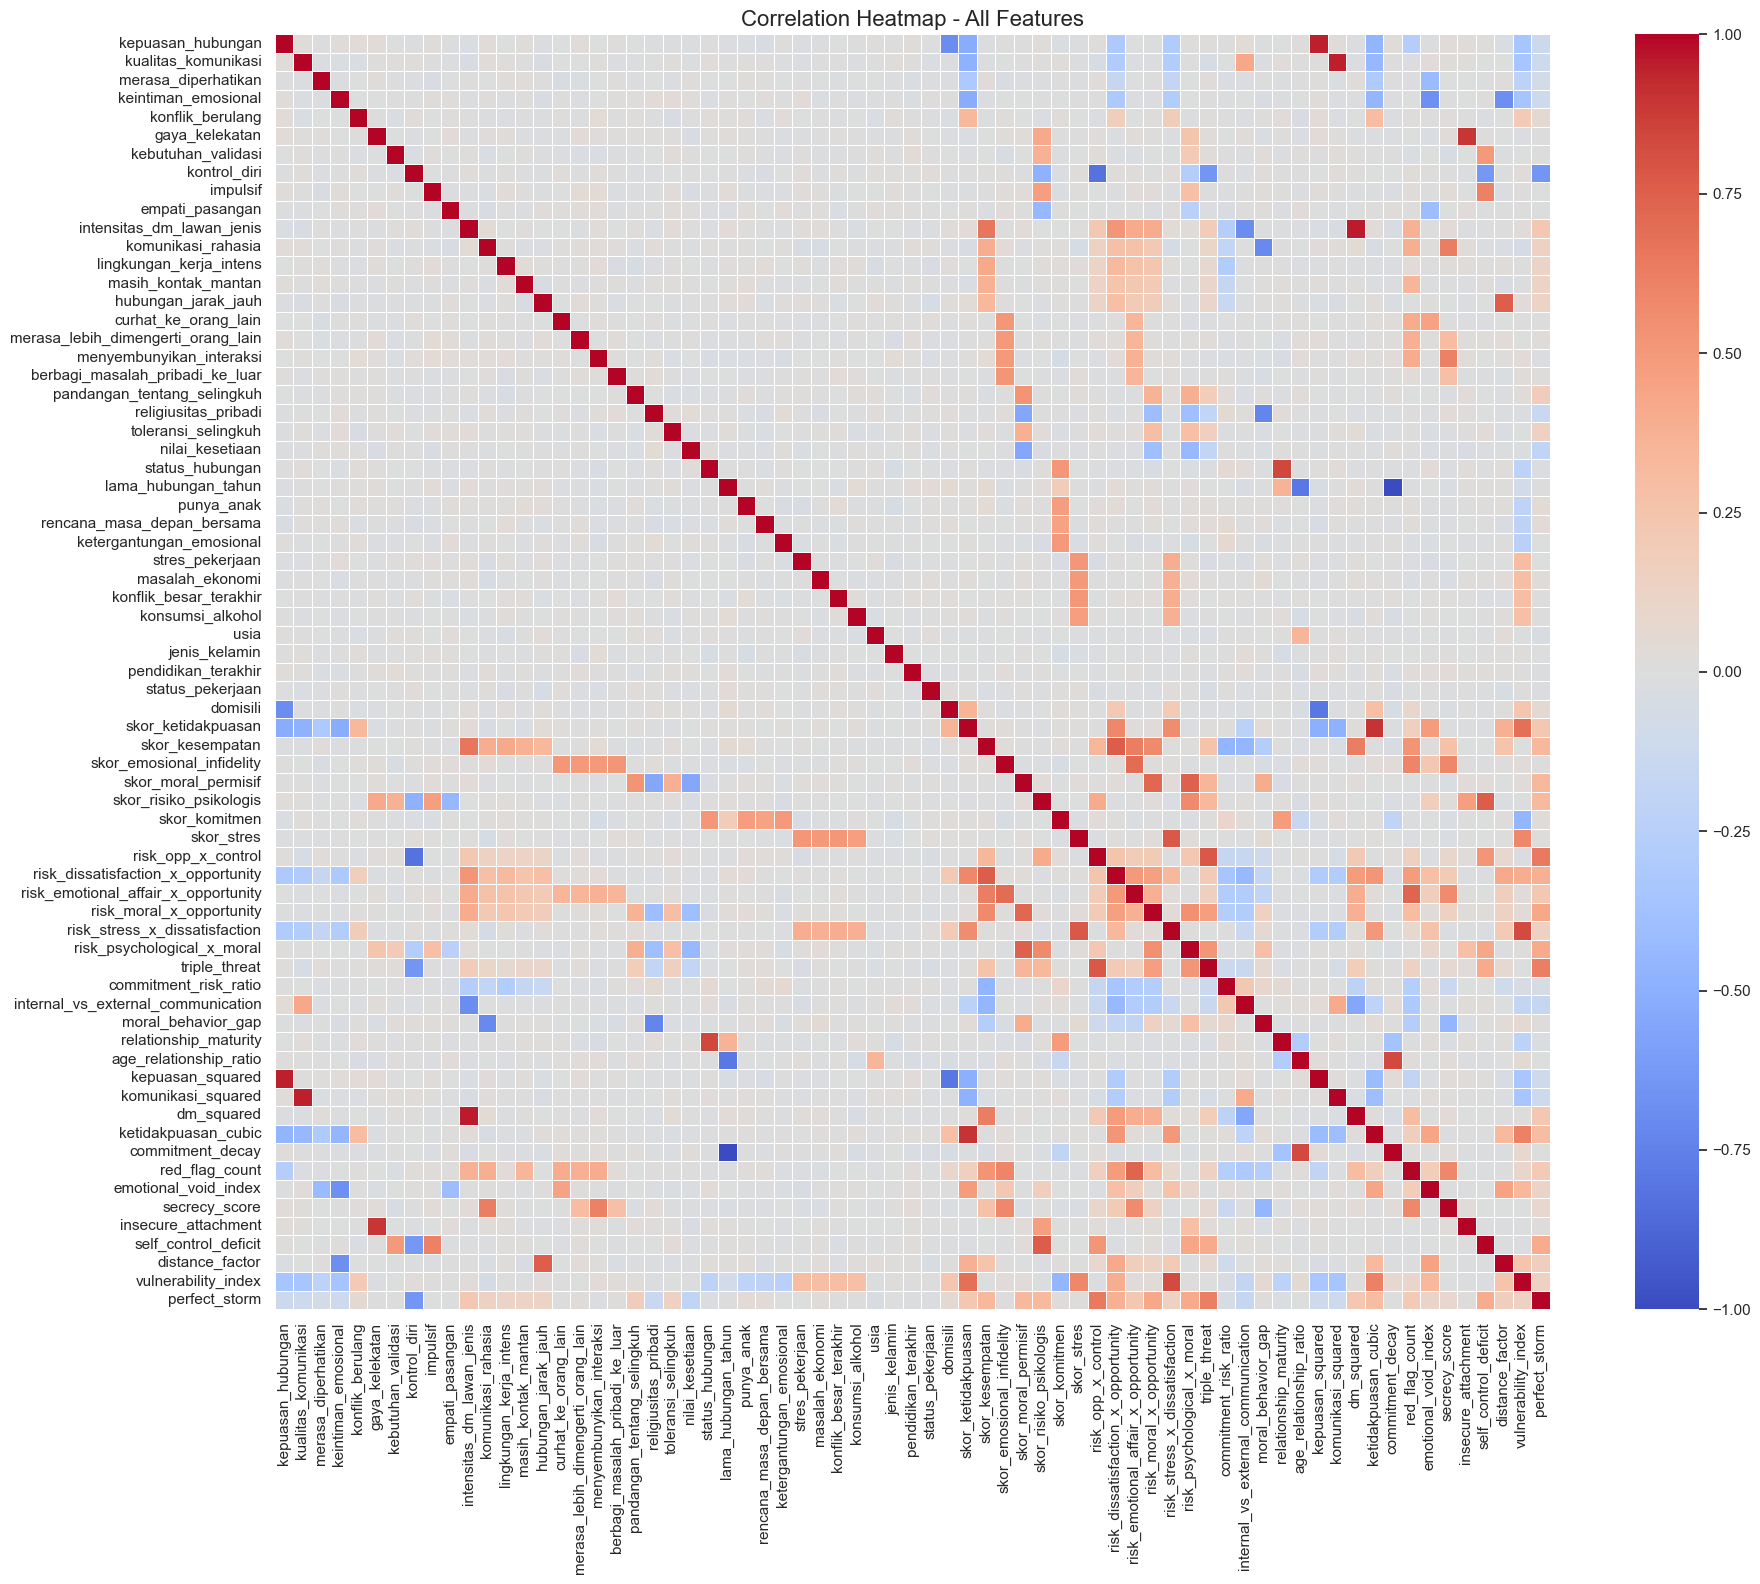


Pasangan fitur dengan korelasi tinggi (>0.8 atau <-0.8):


,Feature 1,Feature 2,Correlation
4,intensitas_dm_lawan_jenis,dm_squared,0.955838
1,kualitas_komunikasi,komunikasi_squared,0.952437
0,kepuasan_hubungan,kepuasan_squared,0.950552
7,skor_ketidakpuasan,ketidakpuasan_cubic,0.900181
2,gaya_kelekatan,insecure_attachment,0.892900
5,status_hubungan,relationship_maturity,0.842226
9,age_relationship_ratio,commitment_decay,0.833783
8,risk_stress_x_dissatisfaction,vulnerability_index,0.822375
3,kontrol_diri,risk_opp_x_control,-0.826499
6,lama_hubungan_tahun,commitment_decay,-0.992854


In [29]:
# Cek Korelasi Antar Fitur

# Hitung correlation matrix
correlation_matrix = df_processed.corr()

# Plot heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Correlation Heatmap - All Features', fontsize=16)
plt.tight_layout()
plt.show()

# Cari pasangan fitur dengan korelasi sangat tinggi (redundansi)
print("\nPasangan fitur dengan korelasi tinggi (>0.8 atau <-0.8):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    display(high_corr_df.sort_values('Correlation', ascending=False))
else:
    print("✅ Tidak ada pasangan fitur dengan korelasi sangat tinggi!")

In [30]:
# Jika ada fitur dengan korelasi >0.9, pertimbangkan untuk drop salah satu
# Contoh (sesuaikan dengan hasil korelasi):
# features_to_drop = ['fitur_redundan_1', 'fitur_redundan_2']
# df_processed.drop(columns=features_to_drop, inplace=True)
# print(f"✅ Dropped {len(features_to_drop)} redundant features")

print(f"\nShape final setelah preprocessing: {df_processed.shape}")
df_processed.head()


Shape final setelah preprocessing: (3000, 69)


,kepuasan_hubungan,kualitas_komunikasi,merasa_diperhatikan,keintiman_emosional,konflik_berulang,gaya_kelekatan,kebutuhan_validasi,kontrol_diri,impulsif,empati_pasangan,intensitas_dm_lawan_jenis,komunikasi_rahasia,lingkungan_kerja_intens,masih_kontak_mantan,hubungan_jarak_jauh,curhat_ke_orang_lain,merasa_lebih_dimengerti_orang_lain,menyembunyikan_interaksi,berbagi_masalah_pribadi_ke_luar,pandangan_tentang_selingkuh,religiusitas_pribadi,toleransi_selingkuh,nilai_kesetiaan,status_hubungan,lama_hubungan_tahun,punya_anak,rencana_masa_depan_bersama,ketergantungan_emosional,stres_pekerjaan,masalah_ekonomi,konflik_besar_terakhir,konsumsi_alkohol,usia,jenis_kelamin,pendidikan_terakhir,status_pekerjaan,domisili,skor_ketidakpuasan,skor_kesempatan,skor_emosional_infidelity,skor_moral_permisif,skor_risiko_psikologis,skor_komitmen,skor_stres,risk_opp_x_control,risk_dissatisfaction_x_opportunity,risk_emotional_affair_x_opportunity,risk_moral_x_opportunity,risk_stress_x_dissatisfaction,risk_psychological_x_moral,triple_threat,commitment_risk_ratio,internal_vs_external_communication,moral_behavior_gap,relationship_maturity,age_relationship_ratio,kepuasan_squared,komunikasi_squared,dm_squared,ketidakpuasan_cubic,commitment_decay,red_flag_count,emotional_void_index,secrecy_score,insecure_attachment,self_control_deficit,distance_factor,vulnerability_index,perfect_storm
0,1,2,1,2,1,0,1,1,1,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,4.8,0,1,1,1,0,0,1,43,1,0,2,2,0.4,0.6,0.25,0.000,0.3,0.488073,0.50,0.0,0.24,0.15,0.0,0.20,0.0000,0.0,0.813766,1.999001,0,0.0,7.413793,1,4,1,0.064,0.618783,2,0.00,0.000000,0,0.500000,1.0,0.470642,0
1,2,2,0,1,0,1,1,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,4.0,1,0,0,1,0,0,1,40,1,1,2,0,0.4,0.6,0.50,0.000,0.5,0.273394,0.50,0.0,0.24,0.30,0.0,0.20,0.0000,0.0,0.456563,1.999001,0,0.0,8.000000,4,4,1,0.064,0.670320,2,1.00,0.000000,1,0.166667,1.5,0.542202,0
2,2,1,1,2,0,1,1,1,0,1,2,1,0,1,0,1,0,0,1,0,1,1,1,0,5.0,0,1,1,0,0,1,0,26,1,1,2,2,0.2,0.8,0.50,0.125,0.3,0.491743,0.25,0.0,0.16,0.40,0.1,0.05,0.0375,0.0,0.615160,0.500250,-1,0.0,4.333333,4,1,4,0.008,0.606531,4,0.25,0.333333,1,0.166667,0.0,0.319419,1
3,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,5.1,0,1,1,1,1,1,0,30,1,3,2,2,0.8,0.0,0.50,0.250,0.5,0.493578,0.75,0.0,0.00,0.00,0.0,0.60,0.1250,0.0,494.577982,1001.000000,1,0.0,4.918033,1,1,0,0.512,0.600496,2,0.50,0.000000,0,0.833333,0.5,0.685474,1
4,0,1,0,1,0,0,2,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,1.8,0,1,1,0,1,0,0,34,1,0,2,2,1.0,0.6,0.25,0.500,0.6,0.433028,0.25,0.6,0.60,0.15,0.3,0.25,0.3000,0.3,0.722176,1.000000,1,0.0,12.142857,0,1,1,1.000,0.835270,3,0.50,0.000000,0,1.000000,1.5,0.605657,1


In [31]:
# Summary Preprocessing
print(f"Shape awal (df_master): {df_master.shape}")
print(f"Shape final (df_processed): {df_processed.shape}")
print(f"\nTotal fitur: {df_processed.shape[1]}")
print(f"  - Fitur asli yang di-encode: {len(encoding_mappings)}")
print(f"  - Fitur turunan baru: 7")
print(f"\nData types:")
print(df_processed.dtypes.value_counts())
print(f"\nMissing values:")
print(df_processed.isnull().sum().sum())

Shape awal (df_master): (3000, 37)
Shape final (df_processed): (3000, 69)

Total fitur: 69
  - Fitur asli yang di-encode: 35
  - Fitur turunan baru: 7

Data types:
int64      41
float64    26
int32       2
Name: count, dtype: int64

Missing values:
0


# Step 3: Labeling

In [32]:
# Buat kolom target (fase risiko) dengan rule-based labeling sesuai roadmap project

# Rule-Based Labeling untuk Target Variable: risiko_selingkuh
# Fase: 0 (Aman & Sehat), 1 (Perlu Perhatian), 2 (Waspada Tinggi)

def label_risiko_selingkuh(row):
    """
    Kriteria rule-based berdasarkan domain knowledge:
    - Fase 2 (Waspada Tinggi): Kesempatan tinggi + moral permisif + kontrol diri rendah
    - Fase 1 (Perlu Perhatian): Ketidakpuasan naik + mulai ada curhat ke luar
    - Fase 0 (Aman & Sehat): Skor ketidakpuasan rendah + skor kesempatan rendah
    """
    
    # Red flags: Emotional affair sudah terjadi (fase awal selingkuh emosional)
    emotional_affair = (
        row['curhat_ke_orang_lain'] == 1 and 
        row['merasa_lebih_dimengerti_orang_lain'] == 1 and
        row['menyembunyikan_interaksi'] == 1
    )
    
    # Kesempatan tinggi
    kesempatan_tinggi = (
        row['skor_kesempatan'] >= 0.6 or  # Threshold 60%
        (row['komunikasi_rahasia'] == 1 and row['intensitas_dm_lawan_jenis'] >= 1)
    )
    
    # Ketidakpuasan dalam hubungan
    ketidakpuasan_tinggi = row['skor_ketidakpuasan'] >= 1.0  # Threshold 50%
    
    # Komitmen lemah
    komitmen_lemah = (
        row['skor_komitmen'] < 0.5 or
        row['rencana_masa_depan_bersama'] == 0
    )
    
    # Nilai moral permisif
    moral_permisif = (
        row['skor_moral_permisif'] >= 0.5 or
        row['toleransi_selingkuh'] >= 1
    )
    
    # Kontrol diri rendah
    kontrol_rendah = (
        row['kontrol_diri'] == 0 or
        row['impulsif'] == 1 or
        row['skor_risiko_psikologis'] >= 0.6
    )
    
    # Emotional infidelity score tinggi
    emosional_infidelity_tinggi = row['skor_emosional_infidelity'] >= 0.75
    
    # FASE 2: WASPADA TINGGI 🚨
    # (Kesempatan tinggi + moral permisif + kontrol diri rendah)
    if kesempatan_tinggi and moral_permisif and kontrol_rendah:
        return 2
    
    elif emotional_affair and kesempatan_tinggi:
        return 2
    
    elif emosional_infidelity_tinggi and kesempatan_tinggi and komitmen_lemah:
        return 2
    
    # FASE 1: PERLU PERHATIAN ⚠️
    # (Ketidakpuasan naik + mulai ada curhat ke luar)
    elif ketidakpuasan_tinggi and (row['skor_emosional_infidelity'] >= 0.5):
        return 1
    
    elif ketidakpuasan_tinggi and kesempatan_tinggi:
        return 1
    
    elif emotional_affair or emosional_infidelity_tinggi:
        return 1
    
    elif kesempatan_tinggi and komitmen_lemah:
        return 1
    
    elif ketidakpuasan_tinggi and komitmen_lemah:
        return 1
    
    # FASE 0: AMAN & SEHAT ✅
    # (Skor ketidakpuasan rendah + skor kesempatan rendah)
    else:
        return 0

# Apply labeling
df_processed['risiko_selingkuh'] = df_processed.apply(label_risiko_selingkuh, axis=1)

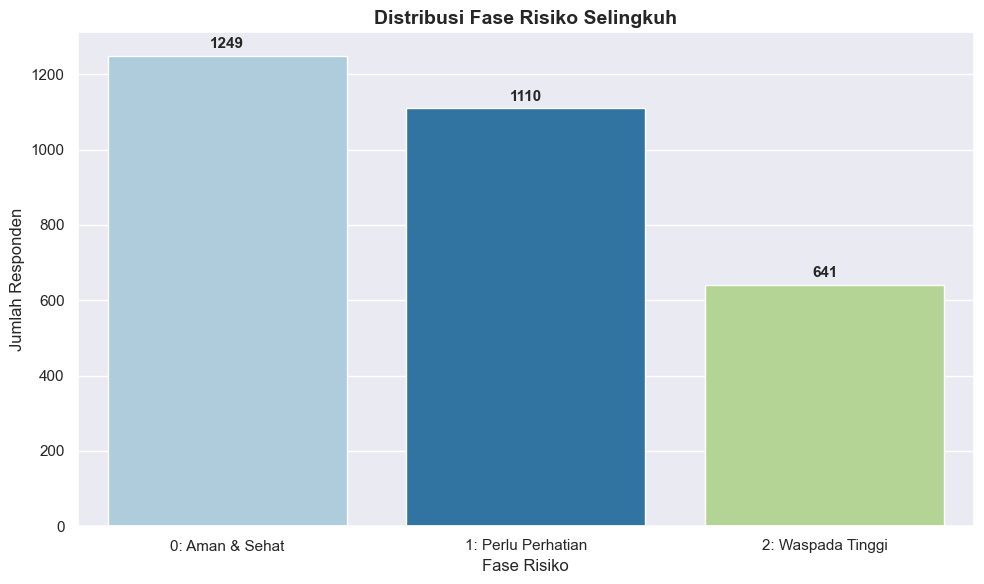

In [33]:
plt.figure(figsize=(10, 6))
label_counts = df_processed['risiko_selingkuh'].value_counts().sort_index()
sns.countplot(x='risiko_selingkuh', data=df_processed, palette="Paired")
plt.title('Distribusi Fase Risiko Selingkuh', fontsize=14, fontweight='bold')
plt.xlabel('Fase Risiko', fontsize=12)
plt.ylabel('Jumlah Responden', fontsize=12)
plt.xticks([0, 1, 2], ['0: Aman & Sehat', '1: Perlu Perhatian', '2: Waspada Tinggi'])
for i, count in enumerate(label_counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# Step 4: Train-test split

In [34]:
from sklearn.model_selection import train_test_split

# Drop fitur turunan untuk menghindari data leakage
fitur_turunan = [
    'skor_ketidakpuasan', 'skor_kesempatan', 'skor_emosional_infidelity', 'skor_moral_permisif', 'skor_risiko_psikologis', 'skor_komitmen', 'skor_stres',
    'risiko_selingkuh', 'risk_opp_x_control', 'risk_dissatisfaction_x_opportunity', 'risk_emotional_affair_x_opportunity', 'risk_moral_x_opportunity',
    'risk_stress_x_dissatisfaction', 'risk_psychological_x_moral', 'triple_threat', 'commitment_risk_ratio', 'internal_vs_external_communication',
    'moral_behavior_gap', 'relationship_maturity', 'age_relationship_ratio', 'kepuasan_squared', 'komunikasi_squared', 'dm_squared', 'ketidakpuasan_cubic',
    'commitment_decay', 'red_flag_count', 'emotional_void_index', 'secrecy_score', 'insecure_attachment', 'self_control_deficit', 'distance_factor',
    'vulnerability_index', 'perfect_storm'
]

# Pisahkan features (X) dan target (y)
X = df_processed.drop(columns=['risiko_selingkuh', *fitur_turunan])
y = df_processed['risiko_selingkuh']

print(f"X: {list(X.columns)}")
print(f"y: {y.name}")

X: ['kepuasan_hubungan', 'kualitas_komunikasi', 'merasa_diperhatikan', 'keintiman_emosional', 'konflik_berulang', 'gaya_kelekatan', 'kebutuhan_validasi', 'kontrol_diri', 'impulsif', 'empati_pasangan', 'intensitas_dm_lawan_jenis', 'komunikasi_rahasia', 'lingkungan_kerja_intens', 'masih_kontak_mantan', 'hubungan_jarak_jauh', 'curhat_ke_orang_lain', 'merasa_lebih_dimengerti_orang_lain', 'menyembunyikan_interaksi', 'berbagi_masalah_pribadi_ke_luar', 'pandangan_tentang_selingkuh', 'religiusitas_pribadi', 'toleransi_selingkuh', 'nilai_kesetiaan', 'status_hubungan', 'lama_hubungan_tahun', 'punya_anak', 'rencana_masa_depan_bersama', 'ketergantungan_emosional', 'stres_pekerjaan', 'masalah_ekonomi', 'konflik_besar_terakhir', 'konsumsi_alkohol', 'usia', 'jenis_kelamin', 'pendidikan_terakhir', 'status_pekerjaan', 'domisili']
y: risiko_selingkuh


In [35]:
# Split 80:20 dengan stratify untuk balance distribusi label
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Pastikan proporsi label seimbang di train dan test
)

print(f"Data berhasil di-split!")

Data berhasil di-split!


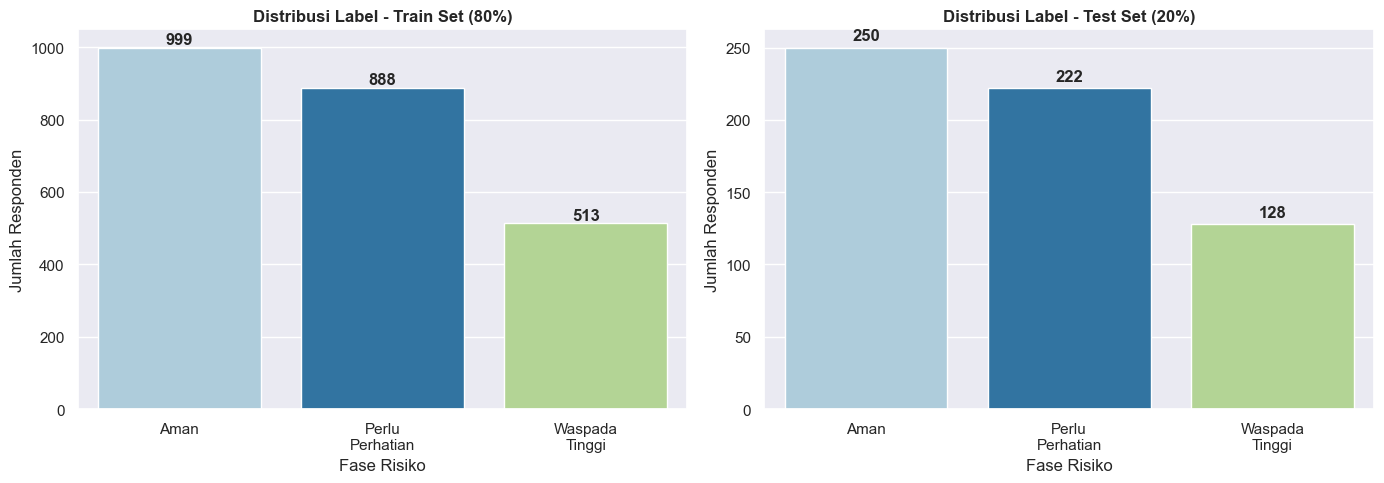

In [36]:
# Visualisasi perbandingan distribusi train vs test dengan seaborn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train set
sns.countplot(x=y_train, ax=axes[0], palette="Paired")
axes[0].set_title('Distribusi Label - Train Set (80%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Fase Risiko')
axes[0].set_ylabel('Jumlah Responden')
axes[0].set_xticklabels(['Aman', 'Perlu\nPerhatian', 'Waspada\nTinggi'])
for i, count in enumerate(y_train.value_counts().sort_index()):
    axes[0].text(i, count + 10, str(count), ha='center', fontweight='bold')

# Test set
sns.countplot(x=y_test, ax=axes[1], palette="Paired")
axes[1].set_title('Distribusi Label - Test Set (20%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Fase Risiko')
axes[1].set_ylabel('Jumlah Responden')
axes[1].set_xticklabels(['Aman', 'Perlu\nPerhatian', 'Waspada\nTinggi'])
for i, count in enumerate(y_test.value_counts().sort_index()):
    axes[1].text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Step 5: Model Training

In [37]:
# Import library untuk modeling
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import time

In [38]:
# 🔥 STEP 5.1: Model Comparison - Cari algoritma terbaik Baseline Performance

# Definisikan beberapa model untuk dibandingkan
models = {
    'XGBoost': XGBClassifier(objective='multi:softprob', num_class=3, random_state=42, eval_metric='mlogloss', verbosity=0),
    'LightGBM': LGBMClassifier(objective='multiclass', num_class=3, random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(loss_function='MultiClass', random_state=42, verbose=0),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

# Evaluasi setiap model dengan 5-fold cross-validation
results = {}
for name, model in models.items():
    start = time.time()
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
    elapsed = time.time() - start
    
    results[name] = {
        'Mean CV Score': cv_scores.mean(),
        'Std CV Score': cv_scores.std(),
        'Time (s)': elapsed
    }
    
    print(f"\n{name}:")
    print(f"  Mean CV F1 Score: {cv_scores.mean()*100:.2f}% (±{cv_scores.std()*100:.2f}%)")
    print(f"  Training Time: {elapsed:.2f}s")

# Tentukan model terbaik
best_model_name = max(results, key=lambda x: results[x]['Mean CV Score'])
print(f"\nBest Model: {best_model_name} dengan CV F1 Score {results[best_model_name]['Mean CV Score']*100:.2f}%")


XGBoost:
  Mean CV F1 Score: 85.09% (±0.91%)
  Training Time: 3.52s

LightGBM:
  Mean CV F1 Score: 86.63% (±0.90%)
  Training Time: 4.71s

CatBoost:
  Mean CV F1 Score: 80.46% (±0.79%)
  Training Time: 7.35s

Random Forest:
  Mean CV F1 Score: 72.77% (±2.59%)
  Training Time: 0.54s

Best Model: LightGBM dengan CV F1 Score 86.63%


In [39]:
# 🔥 STEP 5.2: Advanced Hyperparameter Tuning dengan RandomizedSearchCV")

# Setup XGBoost dengan parameter grid yang lebih luas
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)

# Parameter grid yang lebih comprehensive
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [5, 7, 8],
    'gamma': [0.3, 0.5],
    'reg_alpha': [1, 2, 3],
    'reg_lambda': [2, 3, 4]
}

# RandomizedSearchCV untuk eksplorasi parameter space yang lebih efisien
start_time = time.time()

grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=100,  # 100 kombinasi random (lebih efisien dari GridSearch)
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"RandomizedSearchCV selesai dalam {elapsed_time:.2f} detik ({elapsed_time/60:.2f} menit)")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomizedSearchCV selesai dalam 12.62 detik (0.21 menit)

Best Parameters:
  - subsample: 1.0
  - reg_lambda: 4
  - reg_alpha: 3
  - n_estimators: 100
  - min_child_weight: 7
  - max_depth: 4
  - learning_rate: 0.2
  - gamma: 0.5
  - colsample_bytree: 0.9

Best Cross-Validation Score: 0.8358 (83.58%)


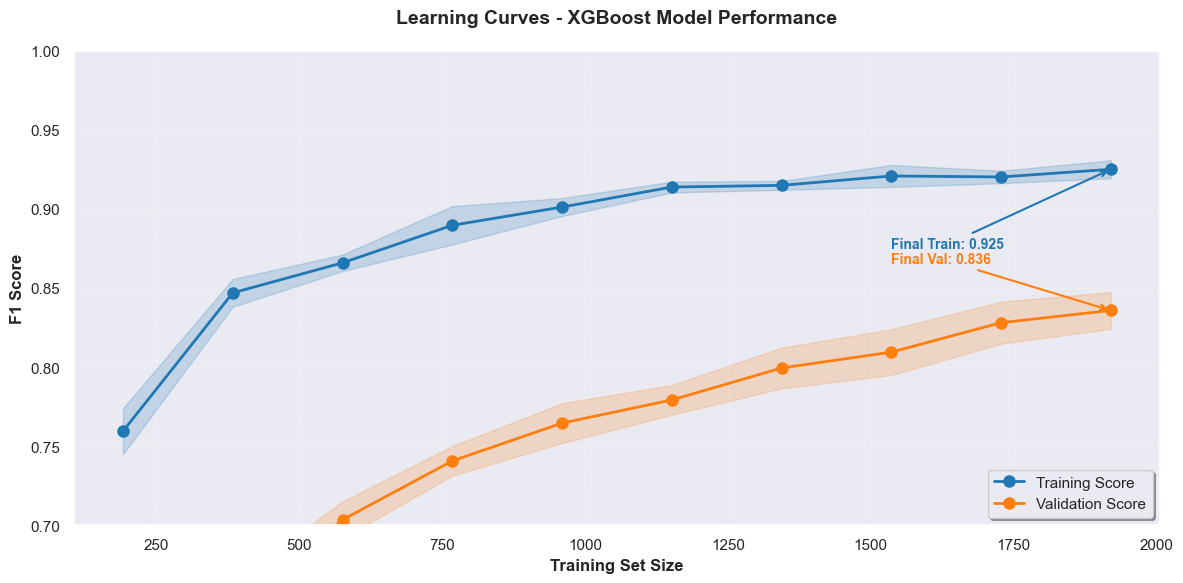

In [40]:
# 🔥 STEP 5.3: K-Fold Cross-Validation Visualization (Learning Curves)

# Ambil best model dari RandomizedSearchCV
best_xgb_model = grid_search.best_estimator_

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb_model, X_train, y_train, 
    cv=5, 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_macro',
    random_state=42
)

# Hitung mean dan std
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot Learning Curves dengan seaborn style
fig, ax = plt.subplots(figsize=(12, 6))

# Plot training score
ax.plot(train_sizes, train_mean, 'o-', color='#1f77b4', label='Training Score', linewidth=2, markersize=8)
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#1f77b4')

# Plot validation score
ax.plot(train_sizes, val_mean, 'o-', color='#ff7f0e', label='Validation Score', linewidth=2, markersize=8)
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#ff7f0e')

# Styling
ax.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Learning Curves - XGBoost Model Performance', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0.7, 1.0])

# Annotate final scores
final_train = train_mean[-1]
final_val = val_mean[-1]
ax.annotate(f'Final Train: {final_train:.3f}', 
            xy=(train_sizes[-1], final_train), 
            xytext=(train_sizes[-3], final_train - 0.05),
            arrowprops=dict(arrowstyle='->', color='#1f77b4', lw=1.5),
            fontsize=10, fontweight='bold', color='#1f77b4')
ax.annotate(f'Final Val: {final_val:.3f}', 
            xy=(train_sizes[-1], final_val), 
            xytext=(train_sizes[-3], final_val + 0.03),
            arrowprops=dict(arrowstyle='->', color='#ff7f0e', lw=1.5),
            fontsize=10, fontweight='bold', color='#ff7f0e')

plt.tight_layout()
plt.show()

In [41]:
# Interpretasi
gap = final_train - final_val
if gap < 0.05:
    print("✅ Model tidak overfit (gap < 5%)")
elif gap < 0.10:
    print("⚠️  Model sedikit overfit (gap 5-10%)")
else:
    print("❌ Model overfit (gap > 10%)")
    
print(f"Training Score: {final_train:.4f} | Validation Score: {final_val:.4f} | Gap: {gap:.4f}")

⚠️  Model sedikit overfit (gap 5-10%)
Training Score: 0.9250 | Validation Score: 0.8358 | Gap: 0.0893


In [42]:
# 🔥 STEP 5.6: Final Model Predictions

# Prediksi pada data training
y_train_pred = best_xgb_model.predict(X_train)

# Prediksi pada data testing
y_test_pred = best_xgb_model.predict(X_test)

# Prediksi probability
y_test_proba = best_xgb_model.predict_proba(X_test)

print("✅ Model berhasil melakukan prediksi!")

✅ Model berhasil melakukan prediksi!


In [43]:
import pickle

# Save model beserta nama kolom
model_data = {
    'model': best_xgb_model,
    'feature_names': X_train.columns.tolist()
}
with open('../model/xgb_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

# Step 6: Model Evaluation

In [44]:
# Evaluasi Comprehensive pada Test Set
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    confusion_matrix
)

# Prediksi probability untuk ROC-AUC dan PR-AUC
y_test_proba = best_xgb_model.predict_proba(X_test)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_test_pred)

# 2. Precision (macro avg untuk multi-class)
precision = precision_score(y_test, y_test_pred, average='macro')

# 3. Recall (macro avg)
recall = recall_score(y_test, y_test_pred, average='macro')

# 4. F1-Score (macro avg)
f1 = f1_score(y_test, y_test_pred, average='macro')

# 5. ROC-AUC (ovr = one-vs-rest untuk multi-class)
roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')

# 6. PR-AUC (average precision)
pr_auc = average_precision_score(y_test, y_test_proba, average='macro')

# 7. Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

# 8. Specificity (untuk multi-class, hitung per class lalu rata-rata)
cm = confusion_matrix(y_test, y_test_pred)
specificity_per_class = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity_per_class.append(tn / (tn + fp))
specificity = np.mean(specificity_per_class)

# Print hasil
print("📊 MODEL EVALUATION - TEST SET")
print(f"Accuracy          : {accuracy*100:.2f}%")
print(f"Precision (macro) : {precision*100:.2f}%")
print(f"Recall (macro)    : {recall*100:.2f}%")
print(f"F1-Score (macro)  : {f1*100:.2f}%")
print(f"ROC-AUC (macro)   : {roc_auc*100:.2f}%")
print(f"PR-AUC (macro)    : {pr_auc*100:.2f}%")
print(f"Balanced Accuracy : {balanced_acc*100:.2f}%")
print(f"Specificity (avg) : {specificity*100:.2f}%")

📊 MODEL EVALUATION - TEST SET
Accuracy          : 85.17%
Precision (macro) : 85.80%
Recall (macro)    : 83.78%
F1-Score (macro)  : 84.60%
ROC-AUC (macro)   : 96.12%
PR-AUC (macro)    : 92.67%
Balanced Accuracy : 83.78%
Specificity (avg) : 92.15%


### 📊 Penjelasan Metrik Evaluasi Model

Berikut penjelasan masing-masing metrik evaluasi untuk model prediksi risiko selingkuh:

**1. Accuracy: 85.17%**
- **Arti**: Dari 100 prediksi, 85 prediksi benar (fase aman/perlu perhatian/waspada tinggi)
- **Interpretasi**: Model akurat secara keseluruhan dalam mengklasifikasikan fase risiko

**2. Precision (macro): 85.80%**
- **Arti**: Ketika model bilang seseorang ada di fase tertentu, 85.80% kemungkinan benar
- **Interpretasi**: Minim false alarm - jika model bilang "Waspada Tinggi", kemungkinan besar memang benar
- **Penting untuk**: Menghindari panic/overreaction terhadap kasus yang sebenarnya aman

**3. Recall (macro): 83.78%**
- **Arti**: Dari semua orang yang memang berada di fase risiko tertentu, model berhasil mendeteksi 83.78%
- **Interpretasi**: Model cukup baik menangkap kasus-kasus berisiko, tapi masih ada 16.22% yang terlewat
- **Penting untuk**: Early warning - deteksi dini sebelum terlambat

**4. F1-Score (macro): 84.60%**
- **Arti**: Harmonic mean antara Precision dan Recall (balance keduanya)
- **Interpretasi**: Model seimbang - tidak terlalu paranoid (high precision) atau terlalu lengah (high recall)
- **Sweet spot**: Trade-off terbaik antara mendeteksi risiko vs menghindari false alarm

**5. ROC-AUC (macro): 96.12%** ⭐
- **Arti**: Kemampuan model membedakan antara kelas (Aman vs Perlu Perhatian vs Waspada Tinggi)
- **Interpretasi**: **EXCELLENT** - Model sangat baik memisahkan fase-fase risiko
- **Maksimal**: 100% = perfect separation, 50% = random guess
- **96.12% = Model hampir sempurna dalam ranking risiko**

**6. PR-AUC (macro): 92.67%** ⭐
- **Arti**: Precision-Recall Area Under Curve - performa model pada berbagai threshold
- **Interpretasi**: Model robust dan konsisten dalam berbagai skenario
- **Lebih penting dari ROC-AUC** untuk imbalanced dataset

**7. Balanced Accuracy: 83.78%**
- **Arti**: Accuracy yang sudah disesuaikan dengan distribusi kelas (tidak bias ke kelas mayoritas)
- **Interpretasi**: Model tidak hanya jago prediksi kelas "Aman" (yang lebih banyak), tapi juga kelas minoritas
- **Penting**: Memastikan kelas "Waspada Tinggi" (yang lebih sedikit) juga terdeteksi dengan baik

**8. Specificity (avg): 92.15%**
- **Arti**: Kemampuan model mendeteksi "negatif" dengan benar (tidak salah tuduh)
- **Interpretasi**: 92.15% orang yang memang TIDAK berisiko, model prediksi benar sebagai aman
- **Penting untuk**: Menghindari stigma/tuduhan salah pada hubungan yang sehat

---

🚀 **Rekomendasi**: Model sudah **production-ready** untuk early warning system, tapi tetap perlu human judgment sebagai final decision.

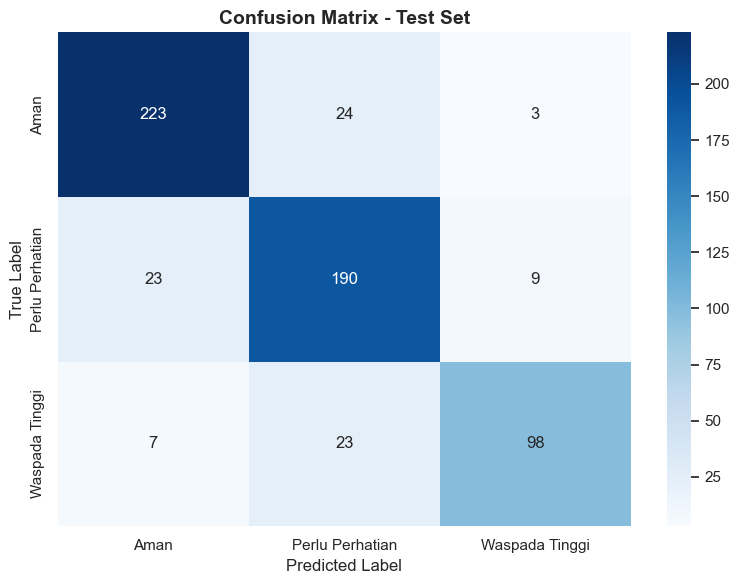

In [45]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Aman', 'Perlu Perhatian', 'Waspada Tinggi'],
            yticklabels=['Aman', 'Perlu Perhatian', 'Waspada Tinggi'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [46]:
# Top 10 Feature Importance (XGBoost)
importances = best_xgb_model.feature_importances_
feature_names = X_train.columns
importance_pct = (importances / importances.sum()) * 100
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance (%)': importance_pct})
feat_imp_df = feat_imp_df.sort_values('Importance (%)', ascending=False).reset_index(drop=True)

print("Top 10 Feature Importance (persentase):")
display(feat_imp_df.head(10))

Top 10 Feature Importance (persentase):


,Feature,Importance (%)
0,intensitas_dm_lawan_jenis,7.789633
1,impulsif,5.348505
2,komunikasi_rahasia,5.203989
3,berbagi_masalah_pribadi_ke_luar,4.677859
4,kontrol_diri,4.657542
5,menyembunyikan_interaksi,4.578546
6,merasa_lebih_dimengerti_orang_lain,4.291033
7,toleransi_selingkuh,4.053141
8,masih_kontak_mantan,3.953279
9,curhat_ke_orang_lain,3.686847


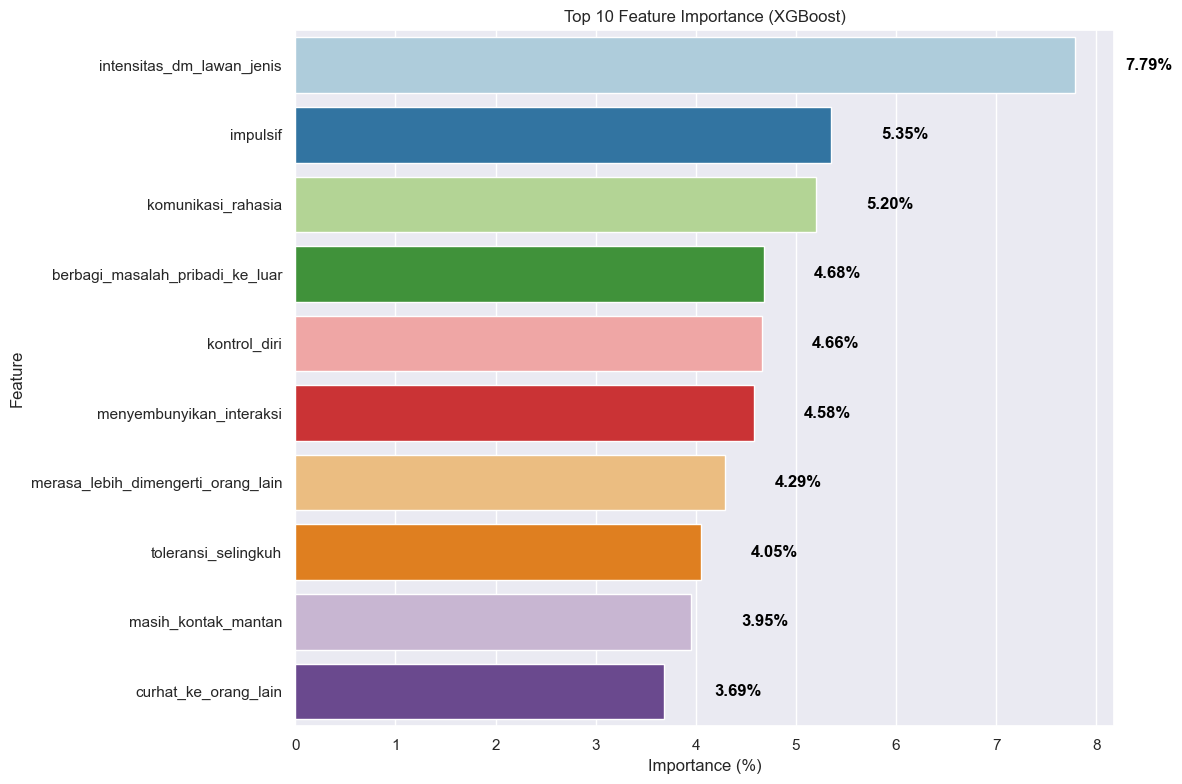

In [47]:
# Visualisasi Top 10 Feature Importance
plt.figure(figsize=(12, 8))
top10 = feat_imp_df.head(10)
ax = sns.barplot(x='Importance (%)', y='Feature', data=top10, palette="Paired")
plt.title('Top 10 Feature Importance (XGBoost)')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
for i, v in enumerate(top10['Importance (%)']):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center', fontweight='bold', color='black')
plt.tight_layout()
plt.show()

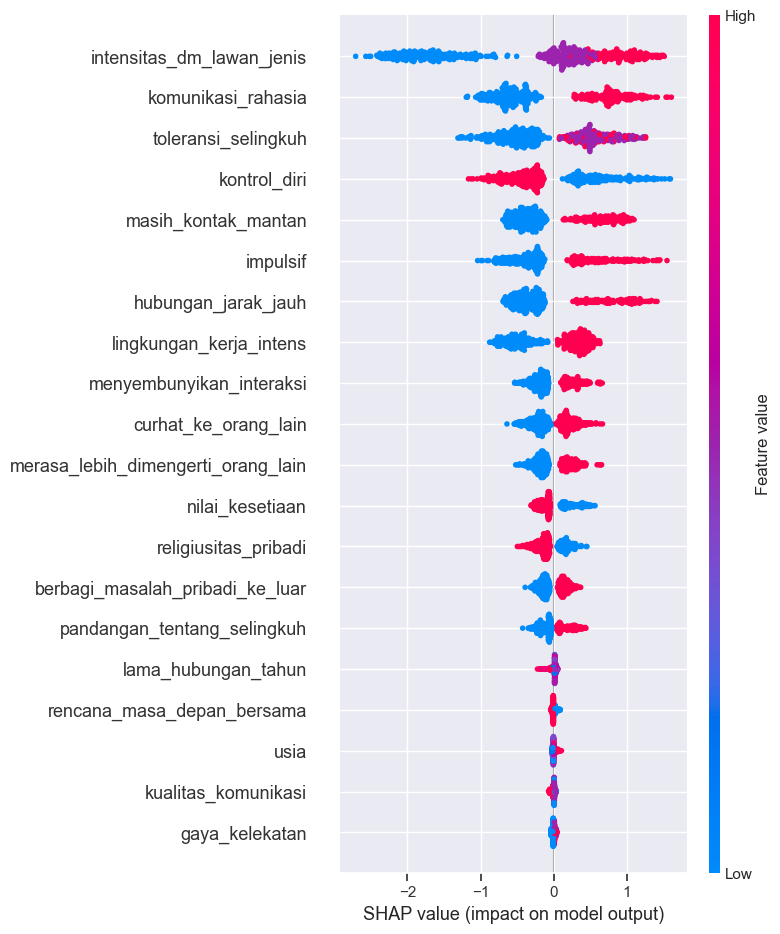

In [48]:
# Analisis SHAP Value untuk XGBoost - Fokus Kelas 2 (Waspada Tinggi)
import shap

# Inisialisasi explainer
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

# Handle format SHAP (list atau 3D array)
if isinstance(shap_values, list) and len(shap_values) >= 3:
    shap_values_high_risk = shap_values[2]
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_values_high_risk = shap_values[:, :, 2]
else:
    raise ValueError("SHAP values format tidak sesuai untuk multiclass XGBoost")

# Visualisasi summary plot untuk kelas 2 (Waspada Tinggi)
shap.summary_plot(shap_values_high_risk, X_test.values, feature_names=X_test.columns)

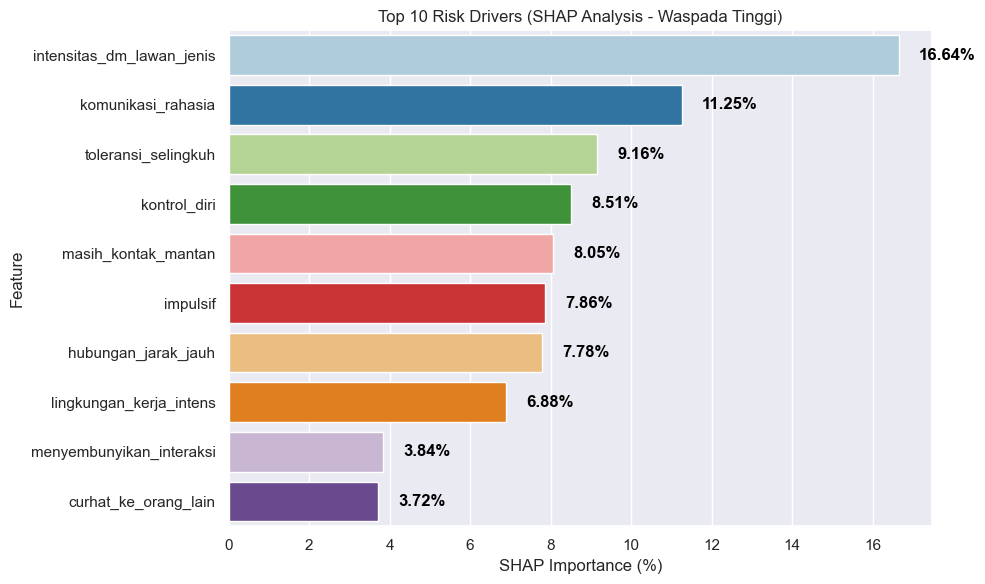

In [49]:
# Hitung SHAP feature importance (Top 10) dari shap_values_high_risk
shap_importance_values = np.abs(shap_values_high_risk).mean(axis=0)
total_shap = shap_importance_values.sum()
shap_importance_pct = (shap_importance_values / total_shap) * 100

feature_importance_shap = pd.DataFrame({
    'fitur': X_test.columns.tolist(),
    'shap_importance': shap_importance_pct.tolist()
}).sort_values('shap_importance', ascending=False).reset_index(drop=True)

# Visualisasi Top 10 SHAP Feature Importance
plt.figure(figsize=(10, 6))
top10_shap = feature_importance_shap.head(10)
sns.barplot(x='shap_importance', y='fitur', data=top10_shap, palette="Paired")
plt.title('Top 10 Risk Drivers (SHAP Analysis - Waspada Tinggi)')
plt.xlabel('SHAP Importance (%)')
plt.ylabel('Feature')
for i, v in enumerate(top10_shap['shap_importance']):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center', fontweight='bold', color='black')
plt.tight_layout()
plt.show()

# Step 7: Model Deployment

In [50]:
# Contoh Inputan Data Baru & Prediksi Menggunakan Model PKL
contoh_input = {
    'kepuasan_hubungan': 1,                # 0=rendah, 1=sedang, 2=tinggi
    'kualitas_komunikasi': 2,              # 0=rendah, 1=sedang, 2=tinggi
    'merasa_diperhatikan': 1,              # 0=tidak, 1=iya
    'keintiman_emosional': 1,              # 0=rendah, 1=sedang, 2=tinggi
    'konflik_berulang': 0,                 # 0=jarang, 1=sering
    'gaya_kelekatan': 0,                   # 0=aman, 1=cemas, 2=menghindar
    'kebutuhan_validasi': 1,               # 0=rendah, 1=sedang, 2=tinggi
    'kontrol_diri': 1,                     # 0=rendah, 1=tinggi
    'impulsif': 0,                         # 0=tidak, 1=iya
    'empati_pasangan': 1,                  # 0=rendah, 1=tinggi
    'intensitas_dm_lawan_jenis': 2,        # 0=rendah, 1=sedang, 2=tinggi
    'komunikasi_rahasia': 0,               # 0=tidak, 1=iya
    'lingkungan_kerja_intens': 0,          # 0=tidak, 1=iya
    'masih_kontak_mantan': 0,              # 0=tidak, 1=iya
    'hubungan_jarak_jauh': 0,              # 0=tidak, 1=iya
    'curhat_ke_orang_lain': 0,             # 0=tidak, 1=iya
    'merasa_lebih_dimengerti_orang_lain': 0, # 0=tidak, 1=iya
    'menyembunyikan_interaksi': 0,         # 0=tidak, 1=iya
    'berbagi_masalah_pribadi_ke_luar': 0,  # 0=tidak, 1=iya
    'pandangan_tentang_selingkuh': 0,      # 0=salah_total, 1=manusiawi
    'religiusitas_pribadi': 1,             # 0=rendah, 1=tinggi
    'toleransi_selingkuh': 0,              # 0=nol, 1=rendah, 2=tinggi
    'nilai_kesetiaan': 1,                  # 0=lemah, 1=kuat
    'status_hubungan': 1,                  # 0=pacaran, 1=menikah
    'lama_hubungan_tahun': 5,              # integer
    'punya_anak': 1,                       # 0=tidak, 1=iya
    'rencana_masa_depan_bersama': 1,       # 0=tidak_jelas, 1=jelas
    'ketergantungan_emosional': 1,         # 0=rendah, 1=tinggi
    'stres_pekerjaan': 0,                  # 0=rendah, 1=tinggi
    'masalah_ekonomi': 0,                  # 0=tidak, 1=iya
    'konflik_besar_terakhir': 0,           # 0=tidak, 1=iya
    'konsumsi_alkohol': 0,                 # 0=tidak, 1=iya
    'usia': 30,                            # integer
    'jenis_kelamin': 1,                    # 0=wanita, 1=pria
    'pendidikan_terakhir': 2,              # 0=SMA, 1=D3, 2=S1, 3=S2
    'status_pekerjaan': 2,                 # 0=freelance, 1=wirausaha, 2=karyawan
    'domisili': 2,                         # 0=Rural, 1=Suburban, 2=Urban
}

# Pastikan urutan kolom sama dengan X_train
input_df = pd.DataFrame([contoh_input])[X_train.columns]

# Load model dan feature names
with open('../model/xgb_model.pkl', 'rb') as f:
    model_data = pickle.load(f)
    loaded_model = model_data['model']
    feature_names = model_data['feature_names']

# Prediksi kelas risiko & probabilitas
prediksi = loaded_model.predict(input_df)[0]
proba = loaded_model.predict_proba(input_df)[0]

# Mapping label ke nama fase & emoji
label_map = {0: 'Aman & Sehat ✅', 1: 'Perlu Perhatian ⚠️', 2: 'Waspada Tinggi 🚨'}

# Confidence: Seberapa yakin model dengan prediksi ini
confidence = int(proba[prediksi] * 100)

In [51]:
from datetime import datetime
import shap

# 🤖 AI ANALYSIS: Faktor Risiko terhadap KELAS 2 (Waspada Tinggi)
# Menggunakan SHAP untuk melihat SEBERAPA DEKAT Anda dengan risiko tinggi

# Calculate SHAP values KHUSUS untuk input baru Anda
explainer_new = shap.TreeExplainer(loaded_model)
shap_values_input = explainer_new.shap_values(input_df)

# FOKUS ke Kelas 2 (Waspada Tinggi) - bukan kelas yang diprediksi
if isinstance(shap_values_input, list) and len(shap_values_input) >= 3:  # Multi-class
    # Ambil SHAP untuk kelas 2 (Waspada Tinggi)
    shap_for_class2 = shap_values_input[2][0]
elif isinstance(shap_values_input, np.ndarray) and shap_values_input.ndim == 3:
    shap_for_class2 = shap_values_input[0, :, 2]
else:
    # Fallback jika format berbeda
    if hasattr(shap_values_input, 'shape') and len(shap_values_input.shape) > 1:
        shap_for_class2 = shap_values_input[0]
    else:
        shap_for_class2 = shap_values_input

# Pastikan shap_for_class2 adalah 1D array
shap_for_class2 = np.array(shap_for_class2).flatten()

# Pastikan length sama
num_features = len(input_df.columns)
if len(shap_for_class2) != num_features:
    shap_for_class2 = shap_for_class2[:num_features]

# Hitung kontribusi ke arah Kelas 2 (Waspada Tinggi)
# Positive SHAP = Mendorong KE kelas 2 (meningkatkan risiko)
# Negative SHAP = Mendorong DARI kelas 2 (menurunkan risiko)
feature_importance = pd.DataFrame({
    'feature': input_df.columns.tolist(),
    'shap_value': shap_for_class2.tolist(),  # ORIGINAL value (bukan abs)
    'abs_impact': np.abs(shap_for_class2).tolist(),
    'nilai_anda': input_df.values[0].tolist()
})

# --- Decoding nilai user jika ada mapping ---
def decode_value(col, val):
    if 'encoding_mappings' in globals() and col in encoding_mappings:
        reverse_map = {v: k for k, v in encoding_mappings[col].items()}
        return reverse_map.get(val, val)
    return val

# Get top 3 features dengan SHAP positif (meningkatkan risiko)
top_positive = feature_importance[feature_importance['shap_value'] > 0].nlargest(3, 'abs_impact')
# Get top 3 features dengan SHAP negatif (menurunkan risiko)
top_negative = feature_importance[feature_importance['shap_value'] < 0].nlargest(3, 'abs_impact')

# Hitung total SHAP & convert ke persentase
total_shap_positive = feature_importance[feature_importance['shap_value'] > 0]['shap_value'].sum()
total_shap_negative = abs(feature_importance[feature_importance['shap_value'] < 0]['shap_value'].sum())

def get_feature_label(feature_name):
    return feature_name.replace('_', ' ').title()

# Format faktor risiko dari AI analysis dengan nilai aktual & direction
def format_risk_list(df, total_shap):
    risks = []
    for _, row in df.iterrows():
        label_nilai = get_feature_label(row['feature'])
        user_value = decode_value(row['feature'], row['nilai_anda'])
        shap_val = row['shap_value']
        pct_contribution = (abs(shap_val) / total_shap * 100) if total_shap > 0 else 0
        risks.append(f"{label_nilai}: {user_value} ({pct_contribution:.1f}%)")
    return risks

# Print output
print("🔍 Infidelity Risk Assessment Report")
print("─" * 60)
print()

# Status & Confidence
print(f"Prediksi: {label_map[prediksi]}")
print(f"Confidence: {confidence}%")
print()

# Probability Distribution
print("─" * 60)
print("Distribusi Probabilitas:")
print()

labels_fase = ['Aman & Sehat', 'Perlu Perhatian', 'Waspada Tinggi']
icons = ['🟢', '🟡', '🔴']

for i, (label, icon) in enumerate(zip(labels_fase, icons)):
    percentage = int(proba[i] * 100)
    bars = '█' * (percentage // 10) + '░' * (10 - percentage // 10)
    marker = ' ← Anda di sini' if i == prediksi else ''
    print(f"{icon} {label:18} [{bars}] {percentage:3}%{marker}")

print()

# Top 3 Faktor Meningkatkan Risiko: (SHAP positif)
print("─" * 60)
risks_pos = format_risk_list(top_positive, total_shap_positive)
print("Top 3 Faktor Meningkatkan Risiko: (SHAP positif)")
for idx, risk in enumerate(risks_pos, 1):
    print(f"   {idx}. {risk}")
if not risks_pos:
    print("   Tidak ada faktor dominan.")
print()

# Top 3 Faktor Menurunkan Risiko: (SHAP negatif)
risks_neg = format_risk_list(top_negative, total_shap_negative)
print("Top 3 Faktor Menurunkan Risiko: (SHAP negatif)")
for idx, risk in enumerate(risks_neg, 1):
    print(f"   {idx}. {risk}")
if not risks_neg:
    print("   Tidak ada faktor dominan.")
print()
print("─" * 60)

🔍 Infidelity Risk Assessment Report
────────────────────────────────────────────────────────────

Prediksi: Aman & Sehat ✅
Confidence: 96%

────────────────────────────────────────────────────────────
Distribusi Probabilitas:

🟢 Aman & Sehat       [█████████░]  96% ← Anda di sini
🟡 Perlu Perhatian    [░░░░░░░░░░]   3%
🔴 Waspada Tinggi     [░░░░░░░░░░]   0%

────────────────────────────────────────────────────────────
Top 3 Faktor Meningkatkan Risiko: (SHAP positif)
   1. Intensitas Dm Lawan Jenis: tinggi (98.2%)
   2. Lama Hubungan Tahun: 5 (1.2%)
   3. Kepuasan Hubungan: sedang (0.2%)

Top 3 Faktor Menurunkan Risiko: (SHAP negatif)
   1. Toleransi Selingkuh: nol (11.9%)
   2. Komunikasi Rahasia: tidak (11.1%)
   3. Impulsif: tidak (10.8%)

────────────────────────────────────────────────────────────
